In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import re
import warnings
import itertools
warnings.simplefilter(action='ignore', category=FutureWarning)
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input, Model
from tensorflow.keras.initializers import RandomUniform, RandomNormal
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D, Reshape, BatchNormalization
from tensorflow.keras.layers import AveragePooling1D, SeparableConv2D, Activation, concatenate, Conv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import KLDivergence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import mean_absolute_error, explained_variance_score, mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.linear_model import RidgeCV
from tensorflow.keras.constraints import non_neg
warnings.resetwarnings()

# Model prototyping

The goal of this notebook is to get a feel for the performance of the two different types of models to be trained.
Specifically, comparison will be made between a naive baseline model, a ridge regression model, and a convolutional neural network model. Because this notebook is simply prototyping, a very small subset of the available data will be used; a single 
feature's time series for a single country, the United States. This single feature is all that will be available to the CNN and Ridge regression models; because eventually the feature data used in the regression is much larger than that used in the CNN training, this might be an unfair comparison.

The main issue for using a very small subset of data is that I believe it will affect the CNN more than the regression, because
the small number of samples influences how well the specific architecture will perform. Regardless I will press on and continue this testing. 

Both will use mean squared error as their loss function, unfortunately this means that I have to use RidgeCV, which means I need to provide my own folds in order to respect time ordering.

Much like how in regression we want to include multiple days of information for prediction,  it may also be benefitial to convolve multiple frames together for the CNN?

For the baseline testing, the ridge regression seems to benefit more from having more features, but in order to make the tests as simir

In [2]:
def country_slice(data, locations):
    # used as convenience function with pandas
    if type(locations)==str:
        return data[data.location==locations]
    else:
        return data[data.location.isin(locations)]
    
def time_slice(data, start, end, indexer='time_index'):
    # used as convenience function with pandas, used to slice custom time index
    if start < 0 and end < 0:
        if start == -1:
            start = data.loc[:, indexer].max()
        else:
            start = data.loc[:, indexer].max()+start
        if end == -1:
            end = data.loc[:, indexer].max()
        else:
            end = data.loc[:, indexer].max()+end
    return data[(data.loc[:, indexer] >= start) & (data.loc[:, indexer] <= end)]

def per_country_plot(data, feature, legend=True):
    # plot time series for all countries
    data.set_index(['time_index', 'location']).loc[:, feature].unstack().plot(legend=legend)
    return None

def per_time_plot(data, feature, legend=True):
    # plot Series for all times (not useful, I meant to do something else)
    data.set_index(['location','time_index']).loc[:, feature].unstack().plot(legend=legend)
    return None

def column_search(df, name, return_style='loc', threshold='contains'):
    # Due to redundant data and large number of columns, remembering the
    # exact names can be a chore. 
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None

def true_predict_plot(y_true, y_naive, y_predict, title='', suptitle='', scale=None,s=None):
    
    # produce figure which compares true and predicted values for naive
    # and predictive models
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,5))
    if scale == 'log':
        ymax = np.max([np.log(1+y_true).max(), np.log(1+y_predict).max()])
        ax1.scatter(np.log(y_true+1), np.log(y_naive+1), s=s,alpha=0.7)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(np.log(y_true+1), np.log(y_predict+1), s=s,alpha=0.7)
        ax2.plot([0, ymax], [0, ymax],color='r')
    else:
        ymax = np.max([y_true.max(), y_predict.max()])
        ax1.scatter(y_true, y_naive, s=s)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(y_true, y_predict, s=s)
        ax2.plot([0, ymax], [0, ymax],color='r')
    ax1.set_xlabel('True value')
    ax1.set_ylabel('Predicted value')
    ax1.set_title('Naive model')

    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted value')
    ax2.set_title(title)
    ax1.grid(True)
    ax2.grid(True)
    plt.suptitle(suptitle)
    plt.show()
    return None

def residual_plot(y_test, y_predict, title='', ax=None):
    # plot the residuals
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_test, y_test-y_predict.ravel(), s=5)
    ax.set_ylabel('Residual')
    ax.set_xlabel('True value')
    ax.grid(True)
    return None

def residual_diff_plots(y_true, y_naive, y_predict,n_days_into_future, n_countries, scale=None):
    
    # plot residuals in addition to the residual per country as
    # line plot
    fig, axes = plt.subplots(1, 2, figsize=(20,5), sharey=True)
    (ax1,ax2) = axes.flatten()
    xrange = range(len(y_true))
    if scale=='log':
        residual_plot(np.log(y_true+1),np.log(y_naive+1), ax=ax1)
        residual_plot(np.log(y_true+1),np.log(y_predict+1), ax=ax2)
    else:
        residual_plot(y_true,y_naive, ax=ax1)
        residual_plot(y_true,y_predict, ax=ax2)
    fig.suptitle('{}-day-into-future predictions'.format(n_days_into_future))
    ax1.set_ylabel('Residual')
    ax2.set_ylabel('Residual')
    ax1.grid(True)
    ax2.grid(True)
    plt.show()
    return None



def create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries):
    for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 2):
        frame_data = model_data[(time_index <= max_date_in_window-1) & 
                                (time_index >= max_date_in_window-frame_size)]
        reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)

        resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
        frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
        if max_date_in_window == start_date:
            print('Starting with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
            X = frame_data_4D.copy()
        else:
            X = np.concatenate((X, frame_data_4D),axis=0)
    print('Ending with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
    y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
    return X, y

def split_Xy(X, y, frame_size, n_validation_frames, n_test_frames, train_test_only=False, model_type='cnn'):
    """ Split into training, validation and test data.
    """
    
    # the indices for the train-validate-test splits for when the predictors are put in a 2-d format.
    train_indices = list(range(n_countries*0, n_countries*(len(X)-(n_validation_frames+n_test_frames))))
    validate_indices = list(range(n_countries*(len(X)-(n_validation_frames+n_test_frames)), n_countries*(len(X)-n_test_frames)))
    test_indices = list(range(n_countries*(len(X)-n_test_frames), n_countries*len(X)))
    indices = (train_indices, validate_indices, test_indices)

    # Note that the last frame (date_range) that exists in X has already been determined by the choice of the number
    # of steps to predict in the future, this is only slicing the frames. 
    if train_test_only:
        X_train= X[:-n_test_frames,:,:,:]
        y_train =  y[:-n_test_frames,:]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_test, y_test)
    else:
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_train= X[:-(n_validation_frames+n_test_frames),:,:,:]
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        X_validate = X[-(n_validation_frames+n_test_frames):-n_test_frames, :, :, :]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_validate, y_validate,
                   X_test, y_test)

    return splits, indices


def flatten_Xy_splits(splits):
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    X_train_flat =np.concatenate(X_train.reshape(X_train.shape[0], X_train.shape[1], -1), axis=0)
    X_validate_flat =np.concatenate(X_validate.reshape(X_validate.shape[0], X_validate.shape[1], -1), axis=0)
    X_test_flat =np.concatenate(X_test.reshape(X_test.shape[0], X_test.shape[1], -1), axis=0)
    y_train_flat = y_train.ravel()
    y_validate_flat = y_validate.ravel()
    y_test_flat = y_test.ravel()
    flat_splits = (X_train_flat , y_train_flat , X_validate_flat , y_validate_flat , X_test_flat , y_test_flat )
    return flat_splits

def model_analysis(y_true, y_naive, y_predict,n_countries, title='',suptitle=''):
    print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
    #     y_predict[y_predict<0]=0
    mse_train_naive = mean_squared_error(y_true.ravel(), y_naive.ravel())
    mse_predict = mean_squared_error(y_true.ravel(), y_predict)
    r2_train_naive = explained_variance_score(y_true.ravel(), y_naive.ravel())
    r2_predict = explained_variance_score(y_true.ravel(), y_predict)

    print('{}-step MSE [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, mse_train_naive, mse_predict))
    print('{}-step R^2 [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, r2_train_naive, r2_predict))

    true_predict_plot(y_true.ravel(), y_naive.ravel(), y_predict, title=title, suptitle=suptitle)
    residual_diff_plots(y_true.ravel(), y_naive.ravel(), y_predict , n_days_into_future, n_countries)
    return None


def normalize_Xy(splits, feature_range=(0., 1.0), normalization_method='minmax',
                        train_test_only=False, feature_indices=None):
    """ Split into training, validation and test data.
    Normalize with respect to some absolute max, just choose 2*absolute max of training set. 

    """
    
    min_, max_ = feature_range
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    feature_minima = X_train[:,:,:,:].min((0,1,2))[np.newaxis,np.newaxis,np.newaxis,:]
    feature_maxima = 2*X_train[:,:,:,:].max((0,1,2))[np.newaxis,np.newaxis,np.newaxis,:]
    feature_denominator = feature_maxima-feature_minima
    # get the shape of each split's array, so that array arithmetic can be done. 
    train_tile_shape = np.array(np.array(X_train.shape)/np.array(feature_maxima.shape),int)
    validate_tile_shape = np.array(np.array(X_validate.shape)/np.array(feature_maxima.shape),int)
    test_tile_shape = np.array(np.array(X_test.shape)/np.array(feature_maxima.shape),int)

    # using X - X_min / (X_max-X_min). Form denominator
    train_denominator = np.tile(feature_denominator, train_tile_shape)
    validate_denominator = np.tile(feature_denominator, validate_tile_shape)
    test_denominator = np.tile(feature_denominator, test_tile_shape)
    
    # and then the minima.
    train_minima = np.tile(feature_minima,train_tile_shape)
    validate_minima = np.tile(feature_minima,validate_tile_shape)
    test_minima = np.tile(feature_minima,test_tile_shape)
    
    # factor of 1/max_ accounts for absolute maximum that is outside of the data (i.e. potential future values). 
    X_train_scaled = (max_-min_)*(X_train - train_minima)/train_denominator
    X_validate_scaled = (max_-min_)*(X_validate - validate_minima)/validate_denominator
    X_test_scaled = (max_-min_)*(X_test - test_minima)/test_denominator

    
    scaled_splits = (X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test) 
    scaling_arrays =  (feature_maxima, feature_minima, feature_denominator)

    return scaled_splits, scaling_arrays

In [3]:
# Import cleaned data produced by other notebook. 
global_data = pd.read_csv('cnn_data.csv',index_col=0)

For the prototype, see what kind of result we get with just the data on the United States, and only use the new_cases_per_million feature.

In [4]:
data = global_data[global_data.location=='United States'].reset_index(drop=True)
# not enough countries have new_recovered_weighted values.
data = data.drop(columns=['date'])
data = data.drop(columns=column_search(data, 'log'))
# data = data[data.time_index>=40]

# Fully connected neural network model

The first need is that the data has to be arranged in a manner that is compatible with the keras API.
This is done by the primary functions I have written to take in a DataFrame and a series of target values,
and then slice all values according to different windows of time. First create said dataframe and initialize
the quantities relevant to data splitting.

In [5]:
model_data = data.copy().loc[:, 'new_cases_per_million'].to_frame()
new_cases_index = column_search(model_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
model_data = model_data.iloc[:, new_cases_index].to_frame(); new_cases_index=0
n_countries = data.location.nunique()
target_data = data.new_cases_per_million
time_index = data.time_index

frame_size = 14
start_date = frame_size + data.time_index.min()

n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1

In [6]:
X, y = create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames)

Starting with frame ranging time_index values: 0 13
Ending with frame ranging time_index values: 146 159


Create the predictors (X) and the target variable (y) which contain the feature information and the time-shifted new cases per million values, used for prediction, respectively.

By iterating over possible leading window dates a 4-d tensor with dimensions given by the following is created:
```X.shape = (n_windows, n_countries, n_time_steps, n_features)```

Now, splitting X intro train, validate, test, is as easy as slicing the first axis. 
Going backwards in time, the testing set contains the next to last most recent day's worth of values. It's not
the last day because the last day has no "future" with which to compare, and so no worthwhile prediction can be
made. The test set is defined by slicing X for its last row(s) (plural if n_test_frames > 1). The validation set that will 
be used is the next 7 days worth of values and the training data is everything else.

The keras api expects a three dimensional tensor, and so after the slicing/partitioning into different sets, the first axis
is concatenated such that the effect dimensions are ```(n_windows*n_countries, n_time_steps, n_features)```.
This is done via the function ```flatten_Xy```. Technically, when initializing the model it expects a 2-d shape. This is because the data is organized as ```(batch_size, time_steps, features)```. In other words, when initializing the model, one gives the api a shape of a single sample. 


Next, it is important to rescale the data, For this purpose, create some arbitrary maximum (twice the normal max) and
use this to rescale values to the interval [0,1] (such that the fictitious maximum equals 1).



In [7]:
scaled_splits, scaling_arrays =  normalize_Xy(splits, feature_range=(0,1.0), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)
# if need to supply folds for sklearn CV regression functions.
(X_nn_train, y_nn_train, X_nn_validate, y_nn_validate, X_nn_test, y_nn_test) = scaled_splits
(train_indices, validate_indices, test_indices) = indices

To ensure that the data has been split correctly, and has the correct values, plot the scaled data's splits based on color, as well as the original supposed order. The order of the values is correct if the original values are black circles directly behind the colored train-validate-test splits circles'.

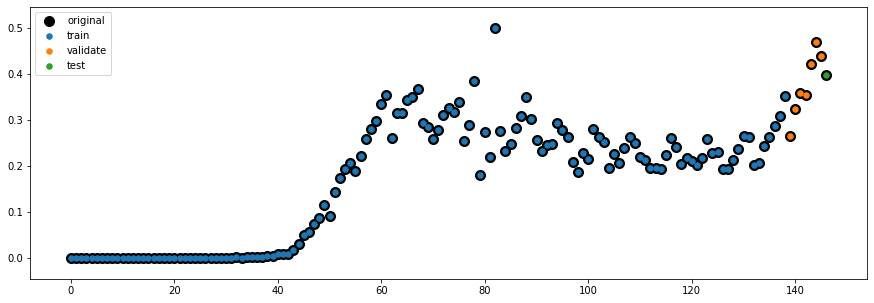

In [8]:
X_scaled_tmp = np.concatenate((X_nn_train,X_nn_validate,X_nn_test), axis=0)

fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.scatter(range(len(X_scaled_tmp)), X_scaled_tmp[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=100,color='k', label='original')
ax.scatter(range(len(scaled_splits[0])), scaled_splits[0][:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=30, label='train')
ax.scatter(range(len(scaled_splits[0]), len(scaled_splits[0])+len(scaled_splits[2])), scaled_splits[2][:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=30, label='validate')
ax.scatter(range(len(scaled_splits[0])+len(scaled_splits[2]), len(X)), X_nn_test[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=30, label='test')
plt.legend()
_ = plt.show()

Scatter plots of train, validate, test sets, by plotting all values in black first I can ensure that the points
are correctly ordered and at the correct values because it makes the rest of the points look like they have black borders.

In [9]:
X_nn_train_model = np.concatenate(X_nn_train.reshape(X_nn_train.shape[0], X_nn_train.shape[1], -1), axis=0)[:,:,np.newaxis]
X_nn_validate_model = np.concatenate(X_nn_validate.reshape(X_nn_validate.shape[0], X_nn_validate.shape[1], -1), axis=0)[:,:,np.newaxis]
X_nn_test_model = np.concatenate(X_nn_test.reshape(X_nn_test.shape[0], X_nn_test.shape[1], -1), axis=0)[:,:,np.newaxis]
y_nn_train_model = y_nn_train.ravel()
y_nn_validate_model = y_nn_validate.ravel()
y_nn_test_model = y_nn_test.ravel()

X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index].ravel()
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index].ravel()
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index].ravel()

To get the correct arrays for the naive baseline, take the values from X instead of y, as y is shifted and makes the process more confusing and or susceptible to mistakes.

The model itself is straightforward. Two dense layers followed by a ReLU activation layer with a single, predictive, output. I try to keep the parameter number at a minimum due to the number of samples currently; and the fact that this trial run is only using a single feature. 

In [10]:
kernel0 = RandomNormal(seed=0)
kernel1 = RandomNormal(seed=1)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
epochs = 10000
learning_rate = 0.001
batch_size = 32

nn_input = Input(shape=X_nn_train.shape[2:])
flat = Flatten()(nn_input)
dense0 = Dense(int(flat.shape[1].value), 
                use_bias=False,
               kernel_initializer=kernel0,

               )(flat)
dense1 = Dense(1, 
                activation='relu',
                use_bias=False,
                kernel_initializer=kernel1,

               )(dense0)

nn = Model(inputs=nn_input, outputs=dense1)
nn.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))

In [12]:
nn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14, 1)]           0         
_________________________________________________________________
flatten (Flatten)            (None, 14)                0         
_________________________________________________________________
dense (Dense)                (None, 14)                196       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 14        
Total params: 210
Trainable params: 210
Non-trainable params: 0
_________________________________________________________________


Fit the model to the scaled training and validation data. 

In [13]:
history = nn.fit(X_nn_train_model, y_nn_train_model, epochs=epochs, validation_data=(X_nn_validate_model, y_nn_validate_model), 
          batch_size=batch_size, verbose=1)

Train on 139 samples, validate on 7 samples
Epoch 1/10000
139/139 [==============================] - 0s 818us/sample - loss: 3855.2468 - val_loss: 13585.5342
Epoch 2/10000
139/139 [==============================] - 0s 43us/sample - loss: 3854.5662 - val_loss: 13582.8057
Epoch 3/10000
139/139 [==============================] - 0s 36us/sample - loss: 3853.5415 - val_loss: 13579.6787
Epoch 4/10000
139/139 [==============================] - 0s 43us/sample - loss: 3852.3427 - val_loss: 13575.9639
Epoch 5/10000
139/139 [==============================] - 0s 43us/sample - loss: 3850.8707 - val_loss: 13571.4580
Epoch 6/10000
139/139 [==============================] - 0s 43us/sample - loss: 3849.1230 - val_loss: 13565.9600
Epoch 7/10000
139/139 [==============================] - 0s 43us/sample - loss: 3846.9574 - val_loss: 13559.3730
Epoch 8/10000
139/139 [==============================] - 0s 43us/sample - loss: 3844.4296 - val_loss: 13551.4287
Epoch 9/10000
139/139 [============================

139/139 [==============================] - 0s 36us/sample - loss: 735.9793 - val_loss: 3840.2527
Epoch 145/10000
139/139 [==============================] - 0s 43us/sample - loss: 720.6049 - val_loss: 3777.4778
Epoch 146/10000
139/139 [==============================] - 0s 43us/sample - loss: 705.5397 - val_loss: 3715.6206
Epoch 147/10000
139/139 [==============================] - 0s 36us/sample - loss: 690.4123 - val_loss: 3655.7341
Epoch 148/10000
139/139 [==============================] - 0s 43us/sample - loss: 675.9337 - val_loss: 3595.3821
Epoch 149/10000
139/139 [==============================] - 0s 43us/sample - loss: 661.9821 - val_loss: 3535.1838
Epoch 150/10000
139/139 [==============================] - 0s 43us/sample - loss: 647.3512 - val_loss: 3477.9470
Epoch 151/10000
139/139 [==============================] - 0s 43us/sample - loss: 633.9686 - val_loss: 3420.8276
Epoch 152/10000
139/139 [==============================] - 0s 36us/sample - loss: 621.2471 - val_loss: 3363.9648

139/139 [==============================] - 0s 43us/sample - loss: 253.4131 - val_loss: 997.9997
Epoch 289/10000
139/139 [==============================] - 0s 43us/sample - loss: 253.3690 - val_loss: 995.2818
Epoch 290/10000
139/139 [==============================] - 0s 43us/sample - loss: 253.2828 - val_loss: 994.7731
Epoch 291/10000
139/139 [==============================] - 0s 43us/sample - loss: 253.2090 - val_loss: 994.6730
Epoch 292/10000
139/139 [==============================] - 0s 36us/sample - loss: 253.1461 - val_loss: 993.3955
Epoch 293/10000
139/139 [==============================] - 0s 43us/sample - loss: 253.0674 - val_loss: 991.8724
Epoch 294/10000
139/139 [==============================] - 0s 50us/sample - loss: 252.9884 - val_loss: 990.3755
Epoch 295/10000
139/139 [==============================] - 0s 50us/sample - loss: 252.9118 - val_loss: 989.8569
Epoch 296/10000
139/139 [==============================] - 0s 43us/sample - loss: 252.8406 - val_loss: 989.7848
Epoch 29

139/139 [==============================] - 0s 43us/sample - loss: 241.1519 - val_loss: 915.6991
Epoch 435/10000
139/139 [==============================] - 0s 43us/sample - loss: 241.0876 - val_loss: 916.8395
Epoch 436/10000
139/139 [==============================] - 0s 43us/sample - loss: 240.9380 - val_loss: 915.5988
Epoch 437/10000
139/139 [==============================] - 0s 41us/sample - loss: 240.8439 - val_loss: 914.8107
Epoch 438/10000
139/139 [==============================] - 0s 36us/sample - loss: 240.7857 - val_loss: 913.9899
Epoch 439/10000
139/139 [==============================] - 0s 43us/sample - loss: 240.6765 - val_loss: 915.0280
Epoch 440/10000
139/139 [==============================] - 0s 43us/sample - loss: 240.5614 - val_loss: 916.0290
Epoch 441/10000
139/139 [==============================] - 0s 43us/sample - loss: 240.4909 - val_loss: 917.5562
Epoch 442/10000
139/139 [==============================] - 0s 36us/sample - loss: 240.3906 - val_loss: 918.6963
Epoch 44

139/139 [==============================] - 0s 43us/sample - loss: 225.7759 - val_loss: 849.8275
Epoch 581/10000
139/139 [==============================] - 0s 43us/sample - loss: 225.7129 - val_loss: 849.2831
Epoch 582/10000
139/139 [==============================] - 0s 43us/sample - loss: 225.5684 - val_loss: 844.4935
Epoch 583/10000
139/139 [==============================] - 0s 43us/sample - loss: 225.4491 - val_loss: 842.4546
Epoch 584/10000
139/139 [==============================] - 0s 43us/sample - loss: 225.3351 - val_loss: 841.1614
Epoch 585/10000
139/139 [==============================] - 0s 50us/sample - loss: 225.2172 - val_loss: 841.4688
Epoch 586/10000
139/139 [==============================] - 0s 36us/sample - loss: 225.0997 - val_loss: 842.7972
Epoch 587/10000
139/139 [==============================] - 0s 43us/sample - loss: 224.9957 - val_loss: 843.4181
Epoch 588/10000
139/139 [==============================] - 0s 43us/sample - loss: 224.8805 - val_loss: 843.1079
Epoch 58

139/139 [==============================] - 0s 57us/sample - loss: 207.3761 - val_loss: 729.0795
Epoch 727/10000
139/139 [==============================] - 0s 50us/sample - loss: 207.2166 - val_loss: 731.2723
Epoch 728/10000
139/139 [==============================] - 0s 50us/sample - loss: 207.1114 - val_loss: 734.5618
Epoch 729/10000
139/139 [==============================] - 0s 57us/sample - loss: 206.9238 - val_loss: 735.2956
Epoch 730/10000
139/139 [==============================] - 0s 50us/sample - loss: 206.7857 - val_loss: 736.3724
Epoch 731/10000
139/139 [==============================] - 0s 43us/sample - loss: 206.6400 - val_loss: 738.7836
Epoch 732/10000
139/139 [==============================] - 0s 43us/sample - loss: 206.4711 - val_loss: 744.1293
Epoch 733/10000
139/139 [==============================] - 0s 58us/sample - loss: 206.3901 - val_loss: 747.9591
Epoch 734/10000
139/139 [==============================] - 0s 58us/sample - loss: 206.2578 - val_loss: 749.2390
Epoch 73

139/139 [==============================] - 0s 43us/sample - loss: 197.4424 - val_loss: 704.9407
Epoch 800/10000
139/139 [==============================] - 0s 58us/sample - loss: 197.3777 - val_loss: 701.3537
Epoch 801/10000
139/139 [==============================] - 0s 65us/sample - loss: 197.2353 - val_loss: 701.8344
Epoch 802/10000
139/139 [==============================] - 0s 58us/sample - loss: 197.0719 - val_loss: 701.8314
Epoch 803/10000
139/139 [==============================] - 0s 43us/sample - loss: 196.9480 - val_loss: 702.3945
Epoch 804/10000
139/139 [==============================] - 0s 50us/sample - loss: 196.8540 - val_loss: 703.9189
Epoch 805/10000
139/139 [==============================] - 0s 43us/sample - loss: 196.7265 - val_loss: 702.6822
Epoch 806/10000
139/139 [==============================] - 0s 50us/sample - loss: 196.5809 - val_loss: 700.9784
Epoch 807/10000
139/139 [==============================] - 0s 43us/sample - loss: 196.5061 - val_loss: 698.8116
Epoch 80

Epoch 872/10000
139/139 [==============================] - 0s 50us/sample - loss: 187.7771 - val_loss: 626.2472
Epoch 873/10000
139/139 [==============================] - 0s 43us/sample - loss: 187.6571 - val_loss: 625.2526
Epoch 874/10000
139/139 [==============================] - 0s 50us/sample - loss: 187.5373 - val_loss: 625.5651
Epoch 875/10000
139/139 [==============================] - 0s 43us/sample - loss: 187.3695 - val_loss: 626.2748
Epoch 876/10000
139/139 [==============================] - 0s 50us/sample - loss: 187.2307 - val_loss: 628.4227
Epoch 877/10000
139/139 [==============================] - 0s 43us/sample - loss: 187.0796 - val_loss: 628.1851
Epoch 878/10000
139/139 [==============================] - 0s 50us/sample - loss: 186.9099 - val_loss: 631.8364
Epoch 879/10000
139/139 [==============================] - 0s 43us/sample - loss: 186.8087 - val_loss: 634.3964
Epoch 880/10000
139/139 [==============================] - 0s 43us/sample - loss: 186.6623 - val_loss: 6

Epoch 1018/10000
139/139 [==============================] - 0s 50us/sample - loss: 168.7150 - val_loss: 539.0612
Epoch 1019/10000
139/139 [==============================] - 0s 50us/sample - loss: 168.5597 - val_loss: 539.0855
Epoch 1020/10000
139/139 [==============================] - 0s 43us/sample - loss: 168.4266 - val_loss: 540.6667
Epoch 1021/10000
139/139 [==============================] - 0s 43us/sample - loss: 168.3284 - val_loss: 542.8115
Epoch 1022/10000
139/139 [==============================] - 0s 43us/sample - loss: 168.2123 - val_loss: 540.3170
Epoch 1023/10000
139/139 [==============================] - 0s 50us/sample - loss: 168.0665 - val_loss: 536.9222
Epoch 1024/10000
139/139 [==============================] - 0s 58us/sample - loss: 167.9653 - val_loss: 535.7671
Epoch 1025/10000
139/139 [==============================] - 0s 43us/sample - loss: 167.8282 - val_loss: 536.1445
Epoch 1026/10000
139/139 [==============================] - 0s 50us/sample - loss: 167.7303 - va

139/139 [==============================] - 0s 57us/sample - loss: 153.1501 - val_loss: 450.8510
Epoch 1163/10000
139/139 [==============================] - 0s 50us/sample - loss: 153.1477 - val_loss: 445.2757
Epoch 1164/10000
139/139 [==============================] - 0s 50us/sample - loss: 153.0405 - val_loss: 443.0687
Epoch 1165/10000
139/139 [==============================] - 0s 43us/sample - loss: 152.9370 - val_loss: 443.6994
Epoch 1166/10000
139/139 [==============================] - 0s 50us/sample - loss: 152.8887 - val_loss: 445.4642
Epoch 1167/10000
139/139 [==============================] - 0s 58us/sample - loss: 152.7458 - val_loss: 442.9362
Epoch 1168/10000
139/139 [==============================] - 0s 50us/sample - loss: 152.6903 - val_loss: 444.1541
Epoch 1169/10000
139/139 [==============================] - 0s 50us/sample - loss: 152.7146 - val_loss: 446.8315
Epoch 1170/10000
139/139 [==============================] - 0s 50us/sample - loss: 152.4422 - val_loss: 444.2511


139/139 [==============================] - 0s 50us/sample - loss: 140.8906 - val_loss: 390.1848
Epoch 1307/10000
139/139 [==============================] - 0s 50us/sample - loss: 140.8322 - val_loss: 390.9519
Epoch 1308/10000
139/139 [==============================] - 0s 57us/sample - loss: 140.7658 - val_loss: 390.5709
Epoch 1309/10000
139/139 [==============================] - 0s 58us/sample - loss: 140.6850 - val_loss: 389.6394
Epoch 1310/10000
139/139 [==============================] - 0s 43us/sample - loss: 140.6479 - val_loss: 389.6200
Epoch 1311/10000
139/139 [==============================] - 0s 43us/sample - loss: 140.5452 - val_loss: 389.7823
Epoch 1312/10000
139/139 [==============================] - 0s 43us/sample - loss: 140.5280 - val_loss: 391.5321
Epoch 1313/10000
139/139 [==============================] - 0s 50us/sample - loss: 140.4173 - val_loss: 391.8993
Epoch 1314/10000
139/139 [==============================] - 0s 50us/sample - loss: 140.4045 - val_loss: 390.5023


139/139 [==============================] - 0s 50us/sample - loss: 132.1881 - val_loss: 344.0970
Epoch 1451/10000
139/139 [==============================] - 0s 43us/sample - loss: 132.0907 - val_loss: 342.0747
Epoch 1452/10000
139/139 [==============================] - 0s 43us/sample - loss: 132.0197 - val_loss: 332.9042
Epoch 1453/10000
139/139 [==============================] - 0s 43us/sample - loss: 131.7042 - val_loss: 325.4546
Epoch 1454/10000
139/139 [==============================] - 0s 43us/sample - loss: 131.9362 - val_loss: 316.9978
Epoch 1455/10000
139/139 [==============================] - 0s 43us/sample - loss: 131.8202 - val_loss: 313.2239
Epoch 1456/10000
139/139 [==============================] - 0s 50us/sample - loss: 131.7394 - val_loss: 311.7219
Epoch 1457/10000
139/139 [==============================] - 0s 50us/sample - loss: 131.7084 - val_loss: 311.1079
Epoch 1458/10000
139/139 [==============================] - 0s 43us/sample - loss: 131.6897 - val_loss: 310.4743


139/139 [==============================] - 0s 50us/sample - loss: 126.0701 - val_loss: 301.9214
Epoch 1595/10000
139/139 [==============================] - 0s 58us/sample - loss: 126.0537 - val_loss: 298.6028
Epoch 1596/10000
139/139 [==============================] - 0s 43us/sample - loss: 125.9287 - val_loss: 296.9392
Epoch 1597/10000
139/139 [==============================] - 0s 43us/sample - loss: 125.8997 - val_loss: 296.2121
Epoch 1598/10000
139/139 [==============================] - 0s 43us/sample - loss: 125.8742 - val_loss: 291.6170
Epoch 1599/10000
139/139 [==============================] - 0s 43us/sample - loss: 125.8733 - val_loss: 286.7638
Epoch 1600/10000
139/139 [==============================] - 0s 50us/sample - loss: 125.6826 - val_loss: 284.4454
Epoch 1601/10000
139/139 [==============================] - 0s 50us/sample - loss: 125.6857 - val_loss: 281.9828
Epoch 1602/10000
139/139 [==============================] - 0s 43us/sample - loss: 125.6202 - val_loss: 280.8844


139/139 [==============================] - 0s 43us/sample - loss: 121.6184 - val_loss: 254.0663
Epoch 1739/10000
139/139 [==============================] - 0s 43us/sample - loss: 121.5862 - val_loss: 254.0317
Epoch 1740/10000
139/139 [==============================] - 0s 36us/sample - loss: 121.6188 - val_loss: 254.9327
Epoch 1741/10000
139/139 [==============================] - 0s 36us/sample - loss: 121.5353 - val_loss: 252.1583
Epoch 1742/10000
139/139 [==============================] - 0s 43us/sample - loss: 121.5345 - val_loss: 251.0804
Epoch 1743/10000
139/139 [==============================] - 0s 50us/sample - loss: 121.4873 - val_loss: 252.1194
Epoch 1744/10000
139/139 [==============================] - 0s 43us/sample - loss: 121.4478 - val_loss: 253.0913
Epoch 1745/10000
139/139 [==============================] - 0s 50us/sample - loss: 121.4637 - val_loss: 255.7473
Epoch 1746/10000
139/139 [==============================] - 0s 50us/sample - loss: 121.4158 - val_loss: 257.4773


139/139 [==============================] - 0s 50us/sample - loss: 118.5543 - val_loss: 228.5433
Epoch 1883/10000
139/139 [==============================] - 0s 43us/sample - loss: 118.5387 - val_loss: 227.1100
Epoch 1884/10000
139/139 [==============================] - 0s 50us/sample - loss: 118.5147 - val_loss: 227.6072
Epoch 1885/10000
139/139 [==============================] - 0s 43us/sample - loss: 118.4734 - val_loss: 228.4235
Epoch 1886/10000
139/139 [==============================] - 0s 50us/sample - loss: 118.4469 - val_loss: 231.1523
Epoch 1887/10000
139/139 [==============================] - 0s 43us/sample - loss: 118.4092 - val_loss: 232.2074
Epoch 1888/10000
139/139 [==============================] - 0s 43us/sample - loss: 118.3750 - val_loss: 234.7115
Epoch 1889/10000
139/139 [==============================] - 0s 50us/sample - loss: 118.3849 - val_loss: 236.2352
Epoch 1890/10000
139/139 [==============================] - 0s 50us/sample - loss: 118.4340 - val_loss: 237.3217


139/139 [==============================] - 0s 36us/sample - loss: 116.2137 - val_loss: 214.0018
Epoch 2027/10000
139/139 [==============================] - 0s 43us/sample - loss: 116.2106 - val_loss: 213.8628
Epoch 2028/10000
139/139 [==============================] - 0s 43us/sample - loss: 116.2440 - val_loss: 210.6315
Epoch 2029/10000
139/139 [==============================] - 0s 43us/sample - loss: 116.1892 - val_loss: 209.8917
Epoch 2030/10000
139/139 [==============================] - 0s 43us/sample - loss: 116.1935 - val_loss: 209.9277
Epoch 2031/10000
139/139 [==============================] - 0s 36us/sample - loss: 116.2132 - val_loss: 211.2671
Epoch 2032/10000
139/139 [==============================] - 0s 43us/sample - loss: 116.1687 - val_loss: 211.7765
Epoch 2033/10000
139/139 [==============================] - 0s 36us/sample - loss: 116.1229 - val_loss: 211.4605
Epoch 2034/10000
139/139 [==============================] - 0s 36us/sample - loss: 116.1258 - val_loss: 211.6955


139/139 [==============================] - 0s 50us/sample - loss: 114.4238 - val_loss: 208.9913
Epoch 2171/10000
139/139 [==============================] - 0s 43us/sample - loss: 114.4110 - val_loss: 208.7580
Epoch 2172/10000
139/139 [==============================] - 0s 43us/sample - loss: 114.3862 - val_loss: 209.7502
Epoch 2173/10000
139/139 [==============================] - 0s 50us/sample - loss: 114.6245 - val_loss: 213.6336
Epoch 2174/10000
139/139 [==============================] - 0s 50us/sample - loss: 114.5586 - val_loss: 214.8918
Epoch 2175/10000
139/139 [==============================] - 0s 43us/sample - loss: 114.3469 - val_loss: 211.3055
Epoch 2176/10000
139/139 [==============================] - 0s 43us/sample - loss: 114.1677 - val_loss: 206.2456
Epoch 2177/10000
139/139 [==============================] - 0s 43us/sample - loss: 114.6294 - val_loss: 199.9877
Epoch 2178/10000
139/139 [==============================] - 0s 50us/sample - loss: 114.2837 - val_loss: 198.1786


139/139 [==============================] - 0s 50us/sample - loss: 112.9589 - val_loss: 195.6031
Epoch 2315/10000
139/139 [==============================] - 0s 43us/sample - loss: 113.0360 - val_loss: 198.0634
Epoch 2316/10000
139/139 [==============================] - 0s 43us/sample - loss: 112.9217 - val_loss: 196.1322
Epoch 2317/10000
139/139 [==============================] - 0s 43us/sample - loss: 112.9487 - val_loss: 194.5447
Epoch 2318/10000
139/139 [==============================] - 0s 43us/sample - loss: 112.8890 - val_loss: 194.6115
Epoch 2319/10000
139/139 [==============================] - 0s 43us/sample - loss: 112.9600 - val_loss: 196.5213
Epoch 2320/10000
139/139 [==============================] - 0s 36us/sample - loss: 112.8771 - val_loss: 196.6038
Epoch 2321/10000
139/139 [==============================] - 0s 43us/sample - loss: 112.8529 - val_loss: 197.1236
Epoch 2322/10000
139/139 [==============================] - 0s 43us/sample - loss: 112.8382 - val_loss: 197.3531


139/139 [==============================] - 0s 36us/sample - loss: 111.7124 - val_loss: 188.9012
Epoch 2459/10000
139/139 [==============================] - 0s 43us/sample - loss: 111.6655 - val_loss: 188.3108
Epoch 2460/10000
139/139 [==============================] - 0s 43us/sample - loss: 111.6874 - val_loss: 187.1802
Epoch 2461/10000
139/139 [==============================] - 0s 43us/sample - loss: 111.6677 - val_loss: 185.4178
Epoch 2462/10000
139/139 [==============================] - 0s 43us/sample - loss: 111.6844 - val_loss: 185.2588
Epoch 2463/10000
139/139 [==============================] - 0s 36us/sample - loss: 111.6874 - val_loss: 185.6347
Epoch 2464/10000
139/139 [==============================] - 0s 43us/sample - loss: 111.6517 - val_loss: 185.0396
Epoch 2465/10000
139/139 [==============================] - 0s 36us/sample - loss: 111.7295 - val_loss: 183.1185
Epoch 2466/10000
139/139 [==============================] - 0s 36us/sample - loss: 111.7036 - val_loss: 183.0753


139/139 [==============================] - 0s 43us/sample - loss: 110.5953 - val_loss: 185.6092
Epoch 2603/10000
139/139 [==============================] - 0s 43us/sample - loss: 110.5433 - val_loss: 186.0376
Epoch 2604/10000
139/139 [==============================] - 0s 36us/sample - loss: 110.5567 - val_loss: 185.8366
Epoch 2605/10000
139/139 [==============================] - 0s 43us/sample - loss: 110.5890 - val_loss: 183.4102
Epoch 2606/10000
139/139 [==============================] - 0s 43us/sample - loss: 110.5349 - val_loss: 182.9855
Epoch 2607/10000
139/139 [==============================] - 0s 43us/sample - loss: 110.5317 - val_loss: 183.4919
Epoch 2608/10000
139/139 [==============================] - 0s 36us/sample - loss: 110.5661 - val_loss: 183.3840
Epoch 2609/10000
139/139 [==============================] - 0s 43us/sample - loss: 110.5155 - val_loss: 184.3458
Epoch 2610/10000
139/139 [==============================] - 0s 43us/sample - loss: 110.4671 - val_loss: 185.7160


139/139 [==============================] - 0s 43us/sample - loss: 109.5804 - val_loss: 184.8986
Epoch 2747/10000
139/139 [==============================] - 0s 43us/sample - loss: 109.6238 - val_loss: 184.8940
Epoch 2748/10000
139/139 [==============================] - 0s 44us/sample - loss: 109.5037 - val_loss: 187.1991
Epoch 2749/10000
139/139 [==============================] - 0s 36us/sample - loss: 109.5561 - val_loss: 187.5916
Epoch 2750/10000
139/139 [==============================] - 0s 43us/sample - loss: 109.6255 - val_loss: 186.9708
Epoch 2751/10000
139/139 [==============================] - 0s 50us/sample - loss: 109.5498 - val_loss: 186.7872
Epoch 2752/10000
139/139 [==============================] - 0s 43us/sample - loss: 109.5460 - val_loss: 186.8319
Epoch 2753/10000
139/139 [==============================] - 0s 44us/sample - loss: 109.5168 - val_loss: 187.5806
Epoch 2754/10000
139/139 [==============================] - 0s 43us/sample - loss: 109.6688 - val_loss: 190.3043


139/139 [==============================] - 0s 43us/sample - loss: 108.6427 - val_loss: 179.6369
Epoch 2891/10000
139/139 [==============================] - 0s 43us/sample - loss: 108.6444 - val_loss: 178.8518
Epoch 2892/10000
139/139 [==============================] - 0s 43us/sample - loss: 108.6752 - val_loss: 179.6357
Epoch 2893/10000
139/139 [==============================] - 0s 43us/sample - loss: 108.6468 - val_loss: 179.7794
Epoch 2894/10000
139/139 [==============================] - 0s 43us/sample - loss: 108.6804 - val_loss: 180.4647
Epoch 2895/10000
139/139 [==============================] - 0s 36us/sample - loss: 108.5879 - val_loss: 178.9050
Epoch 2896/10000
139/139 [==============================] - 0s 36us/sample - loss: 108.8742 - val_loss: 176.6876
Epoch 2897/10000
139/139 [==============================] - 0s 43us/sample - loss: 108.7580 - val_loss: 179.9776
Epoch 2898/10000
139/139 [==============================] - 0s 36us/sample - loss: 108.5795 - val_loss: 181.3654


139/139 [==============================] - 0s 36us/sample - loss: 107.8179 - val_loss: 177.2795
Epoch 3035/10000
139/139 [==============================] - 0s 36us/sample - loss: 107.8202 - val_loss: 177.7775
Epoch 3036/10000
139/139 [==============================] - 0s 43us/sample - loss: 107.8481 - val_loss: 177.6315
Epoch 3037/10000
139/139 [==============================] - 0s 43us/sample - loss: 107.7759 - val_loss: 179.6527
Epoch 3038/10000
139/139 [==============================] - 0s 36us/sample - loss: 107.7912 - val_loss: 180.5977
Epoch 3039/10000
139/139 [==============================] - 0s 36us/sample - loss: 107.7889 - val_loss: 180.8719
Epoch 3040/10000
139/139 [==============================] - 0s 36us/sample - loss: 107.7826 - val_loss: 179.9035
Epoch 3041/10000
139/139 [==============================] - 0s 43us/sample - loss: 107.7940 - val_loss: 179.1147
Epoch 3042/10000
139/139 [==============================] - 0s 43us/sample - loss: 107.8632 - val_loss: 174.8988


139/139 [==============================] - 0s 43us/sample - loss: 107.2707 - val_loss: 167.7117
Epoch 3179/10000
139/139 [==============================] - 0s 50us/sample - loss: 107.1092 - val_loss: 170.0414
Epoch 3180/10000
139/139 [==============================] - 0s 36us/sample - loss: 107.0542 - val_loss: 171.7727
Epoch 3181/10000
139/139 [==============================] - 0s 36us/sample - loss: 107.1084 - val_loss: 173.9594
Epoch 3182/10000
139/139 [==============================] - 0s 38us/sample - loss: 107.0629 - val_loss: 175.3270
Epoch 3183/10000
139/139 [==============================] - 0s 36us/sample - loss: 107.1009 - val_loss: 174.1251
Epoch 3184/10000
139/139 [==============================] - 0s 43us/sample - loss: 107.0706 - val_loss: 175.5287
Epoch 3185/10000
139/139 [==============================] - 0s 36us/sample - loss: 107.0373 - val_loss: 175.9173
Epoch 3186/10000
139/139 [==============================] - 0s 36us/sample - loss: 107.0013 - val_loss: 175.3826


139/139 [==============================] - 0s 36us/sample - loss: 106.4667 - val_loss: 182.0815
Epoch 3323/10000
139/139 [==============================] - 0s 36us/sample - loss: 106.5042 - val_loss: 181.1770
Epoch 3324/10000
139/139 [==============================] - 0s 36us/sample - loss: 106.4781 - val_loss: 183.0753
Epoch 3325/10000
139/139 [==============================] - 0s 36us/sample - loss: 106.4899 - val_loss: 183.1452
Epoch 3326/10000
139/139 [==============================] - 0s 43us/sample - loss: 106.4575 - val_loss: 182.1301
Epoch 3327/10000
139/139 [==============================] - 0s 43us/sample - loss: 106.5213 - val_loss: 180.2146
Epoch 3328/10000
139/139 [==============================] - 0s 43us/sample - loss: 106.4473 - val_loss: 180.0394
Epoch 3329/10000
139/139 [==============================] - 0s 43us/sample - loss: 106.4104 - val_loss: 179.6141
Epoch 3330/10000
139/139 [==============================] - 0s 44us/sample - loss: 106.4190 - val_loss: 178.8777


139/139 [==============================] - 0s 36us/sample - loss: 105.7108 - val_loss: 168.9418
Epoch 3467/10000
139/139 [==============================] - 0s 43us/sample - loss: 105.7594 - val_loss: 167.5557
Epoch 3468/10000
139/139 [==============================] - 0s 36us/sample - loss: 105.8787 - val_loss: 166.3613
Epoch 3469/10000
139/139 [==============================] - 0s 50us/sample - loss: 105.7924 - val_loss: 166.9475
Epoch 3470/10000
139/139 [==============================] - 0s 36us/sample - loss: 105.7339 - val_loss: 168.4725
Epoch 3471/10000
139/139 [==============================] - 0s 43us/sample - loss: 105.9276 - val_loss: 173.3808
Epoch 3472/10000
139/139 [==============================] - 0s 43us/sample - loss: 105.7951 - val_loss: 176.0869
Epoch 3473/10000
139/139 [==============================] - 0s 43us/sample - loss: 105.8274 - val_loss: 177.8596
Epoch 3474/10000
139/139 [==============================] - 0s 43us/sample - loss: 105.7631 - val_loss: 178.0432


139/139 [==============================] - 0s 58us/sample - loss: 105.3898 - val_loss: 161.1513
Epoch 3611/10000
139/139 [==============================] - 0s 57us/sample - loss: 105.3369 - val_loss: 160.6618
Epoch 3612/10000
139/139 [==============================] - 0s 50us/sample - loss: 105.4001 - val_loss: 161.0927
Epoch 3613/10000
139/139 [==============================] - 0s 58us/sample - loss: 105.3533 - val_loss: 161.5544
Epoch 3614/10000
139/139 [==============================] - 0s 57us/sample - loss: 105.3504 - val_loss: 162.7146
Epoch 3615/10000
139/139 [==============================] - 0s 43us/sample - loss: 105.3485 - val_loss: 161.6465
Epoch 3616/10000
139/139 [==============================] - 0s 57us/sample - loss: 105.3034 - val_loss: 162.0819
Epoch 3617/10000
139/139 [==============================] - 0s 57us/sample - loss: 105.3125 - val_loss: 163.7688
Epoch 3618/10000
139/139 [==============================] - 0s 57us/sample - loss: 105.2360 - val_loss: 164.1814


139/139 [==============================] - 0s 43us/sample - loss: 104.7694 - val_loss: 168.8691
Epoch 3755/10000
139/139 [==============================] - 0s 43us/sample - loss: 104.6607 - val_loss: 169.4690
Epoch 3756/10000
139/139 [==============================] - 0s 43us/sample - loss: 104.6587 - val_loss: 170.0899
Epoch 3757/10000
139/139 [==============================] - 0s 43us/sample - loss: 104.6890 - val_loss: 169.8553
Epoch 3758/10000
139/139 [==============================] - 0s 50us/sample - loss: 104.7324 - val_loss: 171.5127
Epoch 3759/10000
139/139 [==============================] - 0s 43us/sample - loss: 104.6659 - val_loss: 171.4744
Epoch 3760/10000
139/139 [==============================] - 0s 43us/sample - loss: 104.6807 - val_loss: 170.0495
Epoch 3761/10000
139/139 [==============================] - 0s 43us/sample - loss: 104.6622 - val_loss: 169.6486
Epoch 3762/10000
139/139 [==============================] - 0s 43us/sample - loss: 104.6354 - val_loss: 169.3044


139/139 [==============================] - 0s 43us/sample - loss: 104.2678 - val_loss: 171.2601
Epoch 3899/10000
139/139 [==============================] - 0s 43us/sample - loss: 104.2484 - val_loss: 171.0054
Epoch 3900/10000
139/139 [==============================] - 0s 43us/sample - loss: 104.2196 - val_loss: 169.8376
Epoch 3901/10000
139/139 [==============================] - 0s 43us/sample - loss: 104.2088 - val_loss: 169.9610
Epoch 3902/10000
139/139 [==============================] - 0s 43us/sample - loss: 104.2080 - val_loss: 169.9281
Epoch 3903/10000
139/139 [==============================] - 0s 50us/sample - loss: 104.2200 - val_loss: 171.4079
Epoch 3904/10000
139/139 [==============================] - 0s 43us/sample - loss: 104.2122 - val_loss: 171.0311
Epoch 3905/10000
139/139 [==============================] - 0s 43us/sample - loss: 104.2010 - val_loss: 170.9190
Epoch 3906/10000
139/139 [==============================] - 0s 43us/sample - loss: 104.2069 - val_loss: 170.5724


139/139 [==============================] - 0s 43us/sample - loss: 103.6957 - val_loss: 169.7325
Epoch 4043/10000
139/139 [==============================] - 0s 43us/sample - loss: 103.8666 - val_loss: 172.6333
Epoch 4044/10000
139/139 [==============================] - 0s 43us/sample - loss: 103.8526 - val_loss: 173.8990
Epoch 4045/10000
139/139 [==============================] - 0s 36us/sample - loss: 103.9141 - val_loss: 174.4926
Epoch 4046/10000
139/139 [==============================] - 0s 50us/sample - loss: 103.9476 - val_loss: 171.9272
Epoch 4047/10000
139/139 [==============================] - 0s 43us/sample - loss: 103.8155 - val_loss: 171.9806
Epoch 4048/10000
139/139 [==============================] - 0s 50us/sample - loss: 103.8608 - val_loss: 171.1333
Epoch 4049/10000
139/139 [==============================] - 0s 43us/sample - loss: 103.8159 - val_loss: 170.8063
Epoch 4050/10000
139/139 [==============================] - 0s 36us/sample - loss: 103.7973 - val_loss: 170.2597


139/139 [==============================] - 0s 50us/sample - loss: 103.4231 - val_loss: 168.6225
Epoch 4187/10000
139/139 [==============================] - 0s 50us/sample - loss: 103.4152 - val_loss: 169.2261
Epoch 4188/10000
139/139 [==============================] - 0s 50us/sample - loss: 103.4248 - val_loss: 169.4574
Epoch 4189/10000
139/139 [==============================] - 0s 50us/sample - loss: 103.4226 - val_loss: 169.0169
Epoch 4190/10000
139/139 [==============================] - 0s 43us/sample - loss: 103.4507 - val_loss: 169.9117
Epoch 4191/10000
139/139 [==============================] - 0s 43us/sample - loss: 103.5062 - val_loss: 169.3795
Epoch 4192/10000
139/139 [==============================] - 0s 50us/sample - loss: 103.5316 - val_loss: 171.6066
Epoch 4193/10000
139/139 [==============================] - 0s 50us/sample - loss: 103.4420 - val_loss: 169.8215
Epoch 4194/10000
139/139 [==============================] - 0s 43us/sample - loss: 103.3994 - val_loss: 168.3533


139/139 [==============================] - 0s 43us/sample - loss: 103.0487 - val_loss: 164.7486
Epoch 4331/10000
139/139 [==============================] - 0s 43us/sample - loss: 103.0467 - val_loss: 163.6304
Epoch 4332/10000
139/139 [==============================] - 0s 43us/sample - loss: 103.2329 - val_loss: 161.7065
Epoch 4333/10000
139/139 [==============================] - 0s 43us/sample - loss: 103.0747 - val_loss: 162.0608
Epoch 4334/10000
139/139 [==============================] - 0s 43us/sample - loss: 103.1027 - val_loss: 161.6846
Epoch 4335/10000
139/139 [==============================] - 0s 50us/sample - loss: 103.1317 - val_loss: 161.9922
Epoch 4336/10000
139/139 [==============================] - 0s 50us/sample - loss: 103.0377 - val_loss: 159.6599
Epoch 4337/10000
139/139 [==============================] - 0s 50us/sample - loss: 103.1625 - val_loss: 157.9117
Epoch 4338/10000
139/139 [==============================] - 0s 43us/sample - loss: 103.1997 - val_loss: 158.7962


Epoch 4402/10000
139/139 [==============================] - 0s 208us/sample - loss: 102.9167 - val_loss: 164.9235
Epoch 4403/10000
139/139 [==============================] - 0s 144us/sample - loss: 103.1484 - val_loss: 169.9224
Epoch 4404/10000
139/139 [==============================] - 0s 72us/sample - loss: 102.9117 - val_loss: 171.0049
Epoch 4405/10000
139/139 [==============================] - 0s 79us/sample - loss: 103.0499 - val_loss: 173.8594
Epoch 4406/10000
139/139 [==============================] - 0s 58us/sample - loss: 103.0227 - val_loss: 174.0319
Epoch 4407/10000
139/139 [==============================] - 0s 43us/sample - loss: 103.0110 - val_loss: 173.9621
Epoch 4408/10000
139/139 [==============================] - 0s 43us/sample - loss: 102.9985 - val_loss: 173.3897
Epoch 4409/10000
139/139 [==============================] - 0s 36us/sample - loss: 102.9988 - val_loss: 170.9005
Epoch 4410/10000
139/139 [==============================] - 0s 50us/sample - loss: 102.9167 - 

139/139 [==============================] - 0s 72us/sample - loss: 102.6225 - val_loss: 168.4958
Epoch 4547/10000
139/139 [==============================] - 0s 43us/sample - loss: 102.6445 - val_loss: 166.5032
Epoch 4548/10000
139/139 [==============================] - 0s 43us/sample - loss: 102.5984 - val_loss: 166.0202
Epoch 4549/10000
139/139 [==============================] - 0s 43us/sample - loss: 102.6235 - val_loss: 165.7939
Epoch 4550/10000
139/139 [==============================] - 0s 43us/sample - loss: 102.5881 - val_loss: 165.8221
Epoch 4551/10000
139/139 [==============================] - 0s 43us/sample - loss: 102.6428 - val_loss: 166.9349
Epoch 4552/10000
139/139 [==============================] - 0s 50us/sample - loss: 102.7262 - val_loss: 164.8648
Epoch 4553/10000
139/139 [==============================] - 0s 43us/sample - loss: 102.5864 - val_loss: 165.9219
Epoch 4554/10000
139/139 [==============================] - 0s 50us/sample - loss: 102.5872 - val_loss: 165.9016


139/139 [==============================] - 0s 50us/sample - loss: 102.3475 - val_loss: 161.0947
Epoch 4691/10000
139/139 [==============================] - 0s 43us/sample - loss: 102.3440 - val_loss: 160.1896
Epoch 4692/10000
139/139 [==============================] - 0s 58us/sample - loss: 102.3520 - val_loss: 159.9260
Epoch 4693/10000
139/139 [==============================] - 0s 43us/sample - loss: 102.3621 - val_loss: 160.3237
Epoch 4694/10000
139/139 [==============================] - 0s 43us/sample - loss: 102.3411 - val_loss: 162.8754
Epoch 4695/10000
139/139 [==============================] - 0s 50us/sample - loss: 102.3301 - val_loss: 164.7249
Epoch 4696/10000
139/139 [==============================] - 0s 43us/sample - loss: 102.3384 - val_loss: 164.9764
Epoch 4697/10000
139/139 [==============================] - 0s 57us/sample - loss: 102.3278 - val_loss: 165.5833
Epoch 4698/10000
139/139 [==============================] - 0s 50us/sample - loss: 102.3457 - val_loss: 165.0406


139/139 [==============================] - 0s 58us/sample - loss: 102.1365 - val_loss: 163.2435
Epoch 4835/10000
139/139 [==============================] - 0s 65us/sample - loss: 102.0758 - val_loss: 163.8636
Epoch 4836/10000
139/139 [==============================] - 0s 72us/sample - loss: 102.0971 - val_loss: 165.3020
Epoch 4837/10000
139/139 [==============================] - 0s 57us/sample - loss: 102.1230 - val_loss: 167.0383
Epoch 4838/10000
139/139 [==============================] - 0s 43us/sample - loss: 102.1362 - val_loss: 167.4269
Epoch 4839/10000
139/139 [==============================] - 0s 65us/sample - loss: 102.0942 - val_loss: 168.4740
Epoch 4840/10000
139/139 [==============================] - 0s 57us/sample - loss: 102.1897 - val_loss: 170.3592
Epoch 4841/10000
139/139 [==============================] - 0s 58us/sample - loss: 102.1513 - val_loss: 170.4550
Epoch 4842/10000
139/139 [==============================] - 0s 43us/sample - loss: 102.1693 - val_loss: 169.9235


139/139 [==============================] - 0s 50us/sample - loss: 101.8591 - val_loss: 164.8402
Epoch 4979/10000
139/139 [==============================] - 0s 50us/sample - loss: 101.8897 - val_loss: 166.0927
Epoch 4980/10000
139/139 [==============================] - 0s 50us/sample - loss: 101.8971 - val_loss: 166.4528
Epoch 4981/10000
139/139 [==============================] - 0s 50us/sample - loss: 101.8764 - val_loss: 167.0483
Epoch 4982/10000
139/139 [==============================] - 0s 43us/sample - loss: 101.8802 - val_loss: 168.7145
Epoch 4983/10000
139/139 [==============================] - 0s 43us/sample - loss: 101.9139 - val_loss: 169.3272
Epoch 4984/10000
139/139 [==============================] - 0s 43us/sample - loss: 102.1324 - val_loss: 171.5578
Epoch 4985/10000
139/139 [==============================] - 0s 50us/sample - loss: 101.9052 - val_loss: 169.8706
Epoch 4986/10000
139/139 [==============================] - 0s 43us/sample - loss: 101.8823 - val_loss: 167.9284


139/139 [==============================] - 0s 43us/sample - loss: 101.6695 - val_loss: 160.9111
Epoch 5123/10000
139/139 [==============================] - 0s 50us/sample - loss: 101.7391 - val_loss: 162.6290
Epoch 5124/10000
139/139 [==============================] - 0s 58us/sample - loss: 101.7615 - val_loss: 164.0297
Epoch 5125/10000
139/139 [==============================] - 0s 43us/sample - loss: 101.7727 - val_loss: 162.1255
Epoch 5126/10000
139/139 [==============================] - 0s 50us/sample - loss: 101.6207 - val_loss: 164.0434
Epoch 5127/10000
139/139 [==============================] - 0s 43us/sample - loss: 101.6163 - val_loss: 165.2652
Epoch 5128/10000
139/139 [==============================] - 0s 43us/sample - loss: 101.6317 - val_loss: 165.6767
Epoch 5129/10000
139/139 [==============================] - 0s 50us/sample - loss: 101.6797 - val_loss: 165.5294
Epoch 5130/10000
139/139 [==============================] - 0s 43us/sample - loss: 101.6498 - val_loss: 166.6378


139/139 [==============================] - 0s 57us/sample - loss: 101.4712 - val_loss: 163.5846
Epoch 5267/10000
139/139 [==============================] - 0s 58us/sample - loss: 101.4184 - val_loss: 165.5923
Epoch 5268/10000
139/139 [==============================] - 0s 50us/sample - loss: 101.6996 - val_loss: 170.2129
Epoch 5269/10000
139/139 [==============================] - 0s 50us/sample - loss: 101.5238 - val_loss: 171.7220
Epoch 5270/10000
139/139 [==============================] - 0s 50us/sample - loss: 101.5844 - val_loss: 172.1159
Epoch 5271/10000
139/139 [==============================] - 0s 43us/sample - loss: 101.6063 - val_loss: 171.5432
Epoch 5272/10000
139/139 [==============================] - 0s 43us/sample - loss: 101.6188 - val_loss: 173.5900
Epoch 5273/10000
139/139 [==============================] - 0s 43us/sample - loss: 101.6477 - val_loss: 173.8562
Epoch 5274/10000
139/139 [==============================] - 0s 43us/sample - loss: 101.6229 - val_loss: 174.1017


139/139 [==============================] - 0s 57us/sample - loss: 101.5290 - val_loss: 166.5001
Epoch 5411/10000
139/139 [==============================] - 0s 57us/sample - loss: 101.3533 - val_loss: 168.1327
Epoch 5412/10000
139/139 [==============================] - 0s 50us/sample - loss: 101.3648 - val_loss: 168.4102
Epoch 5413/10000
139/139 [==============================] - 0s 58us/sample - loss: 101.4072 - val_loss: 166.3870
Epoch 5414/10000
139/139 [==============================] - 0s 72us/sample - loss: 101.2961 - val_loss: 165.7195
Epoch 5415/10000
139/139 [==============================] - 0s 50us/sample - loss: 101.3115 - val_loss: 165.3872
Epoch 5416/10000
139/139 [==============================] - 0s 65us/sample - loss: 101.4409 - val_loss: 161.7659
Epoch 5417/10000
139/139 [==============================] - 0s 58us/sample - loss: 101.2784 - val_loss: 162.1672
Epoch 5418/10000
139/139 [==============================] - 0s 50us/sample - loss: 101.3539 - val_loss: 165.5926


139/139 [==============================] - 0s 43us/sample - loss: 101.0947 - val_loss: 161.1966
Epoch 5555/10000
139/139 [==============================] - 0s 43us/sample - loss: 101.0732 - val_loss: 159.4245
Epoch 5556/10000
139/139 [==============================] - 0s 50us/sample - loss: 101.1486 - val_loss: 158.9748
Epoch 5557/10000
139/139 [==============================] - 0s 43us/sample - loss: 101.2382 - val_loss: 156.8169
Epoch 5558/10000
139/139 [==============================] - 0s 43us/sample - loss: 101.1432 - val_loss: 156.4697
Epoch 5559/10000
139/139 [==============================] - 0s 43us/sample - loss: 101.1860 - val_loss: 156.2907
Epoch 5560/10000
139/139 [==============================] - 0s 43us/sample - loss: 101.1477 - val_loss: 158.5308
Epoch 5561/10000
139/139 [==============================] - 0s 50us/sample - loss: 101.1330 - val_loss: 159.2195
Epoch 5562/10000
139/139 [==============================] - 0s 43us/sample - loss: 101.0640 - val_loss: 160.7834


139/139 [==============================] - 0s 43us/sample - loss: 101.0414 - val_loss: 162.7418
Epoch 5699/10000
139/139 [==============================] - 0s 36us/sample - loss: 100.9608 - val_loss: 162.7168
Epoch 5700/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.9432 - val_loss: 161.5519
Epoch 5701/10000
139/139 [==============================] - 0s 36us/sample - loss: 101.0091 - val_loss: 158.3961
Epoch 5702/10000
139/139 [==============================] - ETA: 0s - loss: 63.54 - 0s 43us/sample - loss: 101.0106 - val_loss: 157.5285
Epoch 5703/10000
139/139 [==============================] - 0s 43us/sample - loss: 101.0165 - val_loss: 158.8771
Epoch 5704/10000
139/139 [==============================] - 0s 43us/sample - loss: 101.0085 - val_loss: 157.4933
Epoch 5705/10000
139/139 [==============================] - 0s 43us/sample - loss: 101.1344 - val_loss: 155.5633
Epoch 5706/10000
139/139 [==============================] - 0s 38us/sample - loss: 101.09

139/139 [==============================] - 0s 50us/sample - loss: 100.8411 - val_loss: 157.0156
Epoch 5843/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.8983 - val_loss: 158.3577
Epoch 5844/10000
139/139 [==============================] - 0s 57us/sample - loss: 100.8261 - val_loss: 158.8260
Epoch 5845/10000
139/139 [==============================] - 0s 50us/sample - loss: 100.8347 - val_loss: 160.4207
Epoch 5846/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.9321 - val_loss: 162.3867
Epoch 5847/10000
139/139 [==============================] - 0s 36us/sample - loss: 100.7789 - val_loss: 160.4498
Epoch 5848/10000
139/139 [==============================] - 0s 58us/sample - loss: 100.8774 - val_loss: 158.7341
Epoch 5849/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.8389 - val_loss: 157.9133
Epoch 5850/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.8401 - val_loss: 157.6099


139/139 [==============================] - 0s 50us/sample - loss: 100.7617 - val_loss: 155.4590
Epoch 5987/10000
139/139 [==============================] - 0s 50us/sample - loss: 101.1407 - val_loss: 158.5037
Epoch 5988/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.6832 - val_loss: 157.4736
Epoch 5989/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.7101 - val_loss: 157.2342
Epoch 5990/10000
139/139 [==============================] - 0s 50us/sample - loss: 100.7086 - val_loss: 156.1469
Epoch 5991/10000
139/139 [==============================] - 0s 50us/sample - loss: 100.7333 - val_loss: 155.8247
Epoch 5992/10000
139/139 [==============================] - 0s 50us/sample - loss: 100.7482 - val_loss: 155.6905
Epoch 5993/10000
139/139 [==============================] - 0s 50us/sample - loss: 100.7609 - val_loss: 156.6223
Epoch 5994/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.7157 - val_loss: 157.0974


139/139 [==============================] - 0s 43us/sample - loss: 100.5612 - val_loss: 161.1859
Epoch 6131/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.5294 - val_loss: 159.5489
Epoch 6132/10000
139/139 [==============================] - 0s 36us/sample - loss: 100.5682 - val_loss: 156.9825
Epoch 6133/10000
139/139 [==============================] - 0s 50us/sample - loss: 100.6104 - val_loss: 154.8127
Epoch 6134/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.7754 - val_loss: 156.2484
Epoch 6135/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.6484 - val_loss: 155.2350
Epoch 6136/10000
139/139 [==============================] - 0s 36us/sample - loss: 100.6722 - val_loss: 156.7046
Epoch 6137/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.5840 - val_loss: 156.4071
Epoch 6138/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.5806 - val_loss: 154.5746


139/139 [==============================] - 0s 43us/sample - loss: 100.6059 - val_loss: 164.6898
Epoch 6275/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.4616 - val_loss: 164.1277
Epoch 6276/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.4403 - val_loss: 162.6121
Epoch 6277/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.4493 - val_loss: 160.8839
Epoch 6278/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.5667 - val_loss: 158.9225
Epoch 6279/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.4694 - val_loss: 158.8952
Epoch 6280/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.4441 - val_loss: 160.7087
Epoch 6281/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.4640 - val_loss: 162.0277
Epoch 6282/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.4657 - val_loss: 162.6915


139/139 [==============================] - 0s 50us/sample - loss: 100.4169 - val_loss: 163.7594
Epoch 6419/10000
139/139 [==============================] - 0s 50us/sample - loss: 100.3725 - val_loss: 165.6164
Epoch 6420/10000
139/139 [==============================] - 0s 50us/sample - loss: 100.3554 - val_loss: 165.1504
Epoch 6421/10000
139/139 [==============================] - 0s 58us/sample - loss: 100.4084 - val_loss: 165.3193
Epoch 6422/10000
139/139 [==============================] - 0s 57us/sample - loss: 100.3448 - val_loss: 163.4976
Epoch 6423/10000
139/139 [==============================] - 0s 50us/sample - loss: 100.3386 - val_loss: 161.6128
Epoch 6424/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.3470 - val_loss: 162.3527
Epoch 6425/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.3759 - val_loss: 162.7720
Epoch 6426/10000
139/139 [==============================] - 0s 50us/sample - loss: 100.3636 - val_loss: 161.7932


139/139 [==============================] - 0s 50us/sample - loss: 100.3714 - val_loss: 163.3427
Epoch 6563/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.2820 - val_loss: 165.1244
Epoch 6564/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.2407 - val_loss: 165.2506
Epoch 6565/10000
139/139 [==============================] - 0s 36us/sample - loss: 100.2488 - val_loss: 164.7390
Epoch 6566/10000
139/139 [==============================] - 0s 36us/sample - loss: 100.2315 - val_loss: 164.0471
Epoch 6567/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.3134 - val_loss: 162.3734
Epoch 6568/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.3010 - val_loss: 161.3000
Epoch 6569/10000
139/139 [==============================] - 0s 36us/sample - loss: 100.3121 - val_loss: 163.0591
Epoch 6570/10000
139/139 [==============================] - 0s 36us/sample - loss: 100.2382 - val_loss: 162.5367


139/139 [==============================] - 0s 43us/sample - loss: 100.1477 - val_loss: 160.1530
Epoch 6707/10000
139/139 [==============================] - 0s 50us/sample - loss: 100.0980 - val_loss: 161.5114
Epoch 6708/10000
139/139 [==============================] - 0s 53us/sample - loss: 100.2469 - val_loss: 163.0569
Epoch 6709/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.2772 - val_loss: 160.1963
Epoch 6710/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.1273 - val_loss: 159.4398
Epoch 6711/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.1224 - val_loss: 158.7307
Epoch 6712/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.1481 - val_loss: 159.1408
Epoch 6713/10000
139/139 [==============================] - 0s 36us/sample - loss: 100.1473 - val_loss: 158.8905
Epoch 6714/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.1300 - val_loss: 157.9697


139/139 [==============================] - 0s 43us/sample - loss: 100.2115 - val_loss: 156.5360
Epoch 6851/10000
139/139 [==============================] - 0s 65us/sample - loss: 100.0683 - val_loss: 157.7963
Epoch 6852/10000
139/139 [==============================] - 0s 65us/sample - loss: 100.0534 - val_loss: 158.2063
Epoch 6853/10000
139/139 [==============================] - 0s 65us/sample - loss: 100.0531 - val_loss: 159.4922
Epoch 6854/10000
139/139 [==============================] - 0s 50us/sample - loss: 100.0329 - val_loss: 160.1637
Epoch 6855/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.0684 - val_loss: 161.3830
Epoch 6856/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.0443 - val_loss: 162.1501
Epoch 6857/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.0505 - val_loss: 163.2955
Epoch 6858/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.0974 - val_loss: 163.6157


Epoch 6995/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.3530 - val_loss: 174.0808
Epoch 6996/10000
139/139 [==============================] - 0s 36us/sample - loss: 100.2113 - val_loss: 172.0052
Epoch 6997/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.2648 - val_loss: 168.9400
Epoch 6998/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.0708 - val_loss: 167.7625
Epoch 6999/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.0634 - val_loss: 167.2497
Epoch 7000/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.0712 - val_loss: 166.5191
Epoch 7001/10000
139/139 [==============================] - 0s 50us/sample - loss: 100.0639 - val_loss: 166.3749
Epoch 7002/10000
139/139 [==============================] - 0s 43us/sample - loss: 100.0144 - val_loss: 164.2973
Epoch 7003/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.9515 - val

Epoch 7068/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.9715 - val_loss: 156.0590
Epoch 7069/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.9920 - val_loss: 157.7270
Epoch 7070/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.9592 - val_loss: 159.8333
Epoch 7071/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.9363 - val_loss: 161.2014
Epoch 7072/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.9278 - val_loss: 160.9581
Epoch 7073/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.9527 - val_loss: 160.9070
Epoch 7074/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.9122 - val_loss: 159.6842
Epoch 7075/10000
139/139 [==============================] - 0s 36us/sample - loss: 99.9026 - val_loss: 158.4215
Epoch 7076/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.9760 - val_loss: 1

139/139 [==============================] - 0s 36us/sample - loss: 99.8785 - val_loss: 160.8576
Epoch 7142/10000
139/139 [==============================] - 0s 36us/sample - loss: 99.8670 - val_loss: 160.2583
Epoch 7143/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.8840 - val_loss: 159.1038
Epoch 7144/10000
139/139 [==============================] - 0s 36us/sample - loss: 99.9045 - val_loss: 159.0619
Epoch 7145/10000
139/139 [==============================] - 0s 36us/sample - loss: 99.8982 - val_loss: 158.3160
Epoch 7146/10000
139/139 [==============================] - 0s 36us/sample - loss: 99.9182 - val_loss: 158.6554
Epoch 7147/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.8926 - val_loss: 157.8450
Epoch 7148/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.9663 - val_loss: 154.9876
Epoch 7149/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.9901 - val_loss: 154.2899
Epoch 715

139/139 [==============================] - 0s 43us/sample - loss: 99.7926 - val_loss: 162.0164
Epoch 7288/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.8274 - val_loss: 161.4968
Epoch 7289/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.7982 - val_loss: 161.1627
Epoch 7290/10000
139/139 [==============================] - 0s 36us/sample - loss: 99.7964 - val_loss: 161.2119
Epoch 7291/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.8076 - val_loss: 161.7678
Epoch 7292/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.8678 - val_loss: 163.7089
Epoch 7293/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.9087 - val_loss: 167.8056
Epoch 7294/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.9289 - val_loss: 169.9825
Epoch 7295/10000
139/139 [==============================] - 0s 36us/sample - loss: 99.9775 - val_loss: 170.8905
Epoch 729

139/139 [==============================] - 0s 72us/sample - loss: 99.7671 - val_loss: 157.4894
Epoch 7434/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.8667 - val_loss: 155.6363
Epoch 7435/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.7923 - val_loss: 156.6989
Epoch 7436/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.7544 - val_loss: 157.6628
Epoch 7437/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.7418 - val_loss: 158.2261
Epoch 7438/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.8471 - val_loss: 157.5772
Epoch 7439/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.8431 - val_loss: 159.1729
Epoch 7440/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.7325 - val_loss: 159.6717
Epoch 7441/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.8020 - val_loss: 159.4686
Epoch 744

139/139 [==============================] - 0s 36us/sample - loss: 99.7172 - val_loss: 158.8648
Epoch 7580/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.6797 - val_loss: 158.4312
Epoch 7581/10000
139/139 [==============================] - 0s 36us/sample - loss: 99.7790 - val_loss: 157.1296
Epoch 7582/10000
139/139 [==============================] - 0s 36us/sample - loss: 99.6964 - val_loss: 158.3434
Epoch 7583/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.6827 - val_loss: 159.7266
Epoch 7584/10000
139/139 [==============================] - 0s 45us/sample - loss: 99.8330 - val_loss: 162.6452
Epoch 7585/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.6908 - val_loss: 162.4758
Epoch 7586/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.7319 - val_loss: 160.7572
Epoch 7587/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.6857 - val_loss: 161.8540
Epoch 758

139/139 [==============================] - 0s 43us/sample - loss: 99.6568 - val_loss: 157.6021
Epoch 7726/10000
139/139 [==============================] - 0s 47us/sample - loss: 99.6594 - val_loss: 157.9806
Epoch 7727/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.6459 - val_loss: 158.3216
Epoch 7728/10000
139/139 [==============================] - 0s 58us/sample - loss: 99.6613 - val_loss: 158.8140
Epoch 7729/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.6498 - val_loss: 158.6727
Epoch 7730/10000
139/139 [==============================] - 0s 36us/sample - loss: 99.6087 - val_loss: 157.0749
Epoch 7731/10000
139/139 [==============================] - 0s 36us/sample - loss: 99.6657 - val_loss: 155.5051
Epoch 7732/10000
139/139 [==============================] - 0s 36us/sample - loss: 99.7336 - val_loss: 156.1043
Epoch 7733/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.6644 - val_loss: 155.8173
Epoch 773

139/139 [==============================] - 0s 36us/sample - loss: 99.5992 - val_loss: 160.6217
Epoch 7872/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.5554 - val_loss: 160.1570
Epoch 7873/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.5724 - val_loss: 160.0569
Epoch 7874/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.5700 - val_loss: 159.0582
Epoch 7875/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.5457 - val_loss: 156.3154
Epoch 7876/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.6598 - val_loss: 154.0633
Epoch 7877/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.7458 - val_loss: 152.4086
Epoch 7878/10000
139/139 [==============================] - 0s 36us/sample - loss: 99.6617 - val_loss: 154.1512
Epoch 7879/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.8836 - val_loss: 158.8253
Epoch 788

139/139 [==============================] - 0s 43us/sample - loss: 99.5879 - val_loss: 167.0240
Epoch 8018/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.5531 - val_loss: 165.5974
Epoch 8019/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.5252 - val_loss: 164.5415
Epoch 8020/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.5936 - val_loss: 162.8317
Epoch 8021/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.5753 - val_loss: 162.0872
Epoch 8022/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.5033 - val_loss: 162.5564
Epoch 8023/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.5394 - val_loss: 163.3704
Epoch 8024/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.5433 - val_loss: 162.4775
Epoch 8025/10000
139/139 [==============================] - 0s 36us/sample - loss: 99.5317 - val_loss: 163.1496
Epoch 802

139/139 [==============================] - 0s 43us/sample - loss: 99.4772 - val_loss: 159.4008
Epoch 8164/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.4916 - val_loss: 157.8512
Epoch 8165/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.5862 - val_loss: 159.0926
Epoch 8166/10000
139/139 [==============================] - 0s 36us/sample - loss: 99.4763 - val_loss: 158.8370
Epoch 8167/10000
139/139 [==============================] - 0s 36us/sample - loss: 99.4889 - val_loss: 158.0978
Epoch 8168/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.6330 - val_loss: 157.1111
Epoch 8169/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.4545 - val_loss: 159.1009
Epoch 8170/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.4745 - val_loss: 159.4979
Epoch 8171/10000
139/139 [==============================] - 0s 36us/sample - loss: 99.5046 - val_loss: 160.7053
Epoch 817

139/139 [==============================] - 0s 57us/sample - loss: 99.4397 - val_loss: 163.8958
Epoch 8310/10000
139/139 [==============================] - 0s 58us/sample - loss: 99.4888 - val_loss: 164.7788
Epoch 8311/10000
139/139 [==============================] - 0s 57us/sample - loss: 99.4838 - val_loss: 164.8141
Epoch 8312/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.5750 - val_loss: 162.9832
Epoch 8313/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.3758 - val_loss: 165.2777
Epoch 8314/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.3610 - val_loss: 169.2368
Epoch 8315/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.5963 - val_loss: 172.9189
Epoch 8316/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.6693 - val_loss: 173.3586
Epoch 8317/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.7156 - val_loss: 174.1118
Epoch 831

Epoch 8455/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.4261 - val_loss: 166.0677
Epoch 8456/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.4269 - val_loss: 165.8459
Epoch 8457/10000
139/139 [==============================] - 0s 53us/sample - loss: 99.4128 - val_loss: 165.1914
Epoch 8458/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.4220 - val_loss: 164.2425
Epoch 8459/10000
139/139 [==============================] - 0s 36us/sample - loss: 99.4268 - val_loss: 164.1456
Epoch 8460/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.4456 - val_loss: 163.9408
Epoch 8461/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.4243 - val_loss: 164.0525
Epoch 8462/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.4916 - val_loss: 162.2567
Epoch 8463/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.3880 - val_loss: 1

139/139 [==============================] - 0s 43us/sample - loss: 99.3490 - val_loss: 159.5024
Epoch 8601/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.3452 - val_loss: 160.0502
Epoch 8602/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.3412 - val_loss: 160.1537
Epoch 8603/10000
139/139 [==============================] - ETA: 0s - loss: 50.77 - 0s 50us/sample - loss: 99.3473 - val_loss: 160.0252
Epoch 8604/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.3325 - val_loss: 160.7653
Epoch 8605/10000
139/139 [==============================] - 0s 58us/sample - loss: 99.3366 - val_loss: 161.1318
Epoch 8606/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.2992 - val_loss: 162.3902
Epoch 8607/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.3162 - val_loss: 164.3339
Epoch 8608/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.4354 - val_

139/139 [==============================] - 0s 50us/sample - loss: 99.4760 - val_loss: 169.2686
Epoch 8674/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.4289 - val_loss: 167.7295
Epoch 8675/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.4178 - val_loss: 164.4615
Epoch 8676/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.3718 - val_loss: 161.9669
Epoch 8677/10000
139/139 [==============================] - 0s 57us/sample - loss: 99.3347 - val_loss: 160.9286
Epoch 8678/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.3175 - val_loss: 159.5723
Epoch 8679/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.2952 - val_loss: 158.5145
Epoch 8680/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.3102 - val_loss: 157.3104
Epoch 8681/10000
139/139 [==============================] - 0s 65us/sample - loss: 99.3376 - val_loss: 154.9091
Epoch 868

139/139 [==============================] - 0s 50us/sample - loss: 99.3377 - val_loss: 160.0916
Epoch 8747/10000
139/139 [==============================] - 0s 86us/sample - loss: 99.3197 - val_loss: 157.6639
Epoch 8748/10000
139/139 [==============================] - 0s 122us/sample - loss: 99.3140 - val_loss: 157.3965
Epoch 8749/10000
139/139 [==============================] - 0s 101us/sample - loss: 99.3276 - val_loss: 156.7940
Epoch 8750/10000
139/139 [==============================] - 0s 65us/sample - loss: 99.3518 - val_loss: 157.6514
Epoch 8751/10000
139/139 [==============================] - 0s 57us/sample - loss: 99.3329 - val_loss: 157.4186
Epoch 8752/10000
139/139 [==============================] - 0s 57us/sample - loss: 99.3237 - val_loss: 158.9358
Epoch 8753/10000
139/139 [==============================] - 0s 72us/sample - loss: 99.2930 - val_loss: 159.4049
Epoch 8754/10000
139/139 [==============================] - 0s 57us/sample - loss: 99.3285 - val_loss: 160.0221
Epoch 8

139/139 [==============================] - 0s 50us/sample - loss: 99.4005 - val_loss: 166.8836
Epoch 8893/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.3155 - val_loss: 168.3414
Epoch 8894/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.4774 - val_loss: 169.7995
Epoch 8895/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.4082 - val_loss: 168.0837
Epoch 8896/10000
139/139 [==============================] - 0s 36us/sample - loss: 99.4476 - val_loss: 165.8674
Epoch 8897/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.3414 - val_loss: 164.8163
Epoch 8898/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.2976 - val_loss: 164.6299
Epoch 8899/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.2972 - val_loss: 164.6352
Epoch 8900/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.2845 - val_loss: 164.2202
Epoch 890

139/139 [==============================] - 0s 43us/sample - loss: 99.2181 - val_loss: 161.3497
Epoch 9039/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.2190 - val_loss: 160.8488
Epoch 9040/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.2221 - val_loss: 159.6840
Epoch 9041/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.1989 - val_loss: 157.5481
Epoch 9042/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.3807 - val_loss: 156.2989
Epoch 9043/10000
139/139 [==============================] - 0s 36us/sample - loss: 99.3356 - val_loss: 158.3821
Epoch 9044/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.3015 - val_loss: 157.1987
Epoch 9045/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.2497 - val_loss: 156.4297
Epoch 9046/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.2961 - val_loss: 155.5544
Epoch 904

139/139 [==============================] - 0s 43us/sample - loss: 99.2353 - val_loss: 158.5942
Epoch 9185/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.2764 - val_loss: 160.1660
Epoch 9186/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.1963 - val_loss: 160.0532
Epoch 9187/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.1872 - val_loss: 159.3085
Epoch 9188/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.2140 - val_loss: 158.6264
Epoch 9189/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.2419 - val_loss: 157.6079
Epoch 9190/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.2070 - val_loss: 158.6714
Epoch 9191/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.3096 - val_loss: 160.1472
Epoch 9192/10000
139/139 [==============================] - 0s 39us/sample - loss: 99.2032 - val_loss: 159.7076
Epoch 919

Epoch 9330/10000
139/139 [==============================] - 0s 58us/sample - loss: 99.2113 - val_loss: 156.4351
Epoch 9331/10000
139/139 [==============================] - 0s 65us/sample - loss: 99.1993 - val_loss: 156.8327
Epoch 9332/10000
139/139 [==============================] - 0s 72us/sample - loss: 99.2879 - val_loss: 159.0368
Epoch 9333/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.2565 - val_loss: 159.8424
Epoch 9334/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.2448 - val_loss: 160.2758
Epoch 9335/10000
139/139 [==============================] - 0s 58us/sample - loss: 99.1744 - val_loss: 159.2612
Epoch 9336/10000
139/139 [==============================] - 0s 57us/sample - loss: 99.1701 - val_loss: 157.6005
Epoch 9337/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.2388 - val_loss: 155.3753
Epoch 9338/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.2701 - val_loss: 1

139/139 [==============================] - 0s 44us/sample - loss: 99.2902 - val_loss: 154.0974
Epoch 9404/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.2166 - val_loss: 157.3504
Epoch 9405/10000
139/139 [==============================] - 0s 36us/sample - loss: 99.3267 - val_loss: 160.2802
Epoch 9406/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.1665 - val_loss: 160.1513
Epoch 9407/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.2176 - val_loss: 160.1790
Epoch 9408/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.1309 - val_loss: 163.4654
Epoch 9409/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.1592 - val_loss: 165.0426
Epoch 9410/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.1774 - val_loss: 165.9790
Epoch 9411/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.1965 - val_loss: 166.4287
Epoch 941

139/139 [==============================] - 0s 43us/sample - loss: 99.1036 - val_loss: 156.7458
Epoch 9550/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.4059 - val_loss: 153.9566
Epoch 9551/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.2761 - val_loss: 154.2603
Epoch 9552/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.2659 - val_loss: 153.9708
Epoch 9553/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.2525 - val_loss: 155.4633
Epoch 9554/10000
139/139 [==============================] - 0s 36us/sample - loss: 99.2163 - val_loss: 155.5348
Epoch 9555/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.2722 - val_loss: 157.0537
Epoch 9556/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.1720 - val_loss: 157.5995
Epoch 9557/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.1621 - val_loss: 158.2186
Epoch 955

139/139 [==============================] - 0s 43us/sample - loss: 99.1615 - val_loss: 160.4689
Epoch 9623/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.1240 - val_loss: 160.2357
Epoch 9624/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.1180 - val_loss: 160.6042
Epoch 9625/10000
139/139 [==============================] - 0s 36us/sample - loss: 99.1415 - val_loss: 161.5946
Epoch 9626/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.2821 - val_loss: 164.8329
Epoch 9627/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.2072 - val_loss: 165.7712
Epoch 9628/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.1795 - val_loss: 165.3094
Epoch 9629/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.1739 - val_loss: 162.7779
Epoch 9630/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.1386 - val_loss: 159.8666
Epoch 963

139/139 [==============================] - 0s 36us/sample - loss: 99.0765 - val_loss: 162.2938
Epoch 9696/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.0735 - val_loss: 164.1695
Epoch 9697/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.0778 - val_loss: 167.4268
Epoch 9698/10000
139/139 [==============================] - 0s 45us/sample - loss: 99.2691 - val_loss: 170.5185
Epoch 9699/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.2719 - val_loss: 171.8882
Epoch 9700/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.3787 - val_loss: 172.3860
Epoch 9701/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.3641 - val_loss: 169.6066
Epoch 9702/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.2688 - val_loss: 169.2230
Epoch 9703/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.2174 - val_loss: 166.7090
Epoch 970

139/139 [==============================] - 0s 43us/sample - loss: 99.1459 - val_loss: 157.8737
Epoch 9842/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.1765 - val_loss: 158.5754
Epoch 9843/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.0956 - val_loss: 157.9838
Epoch 9844/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.1286 - val_loss: 157.6631
Epoch 9845/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.1031 - val_loss: 159.0395
Epoch 9846/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.1043 - val_loss: 160.8815
Epoch 9847/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.1519 - val_loss: 162.3459
Epoch 9848/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.1294 - val_loss: 163.5644
Epoch 9849/10000
139/139 [==============================] - 0s 36us/sample - loss: 99.1736 - val_loss: 164.3411
Epoch 985

139/139 [==============================] - 0s 50us/sample - loss: 99.0988 - val_loss: 165.7649
Epoch 9915/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.1726 - val_loss: 166.5448
Epoch 9916/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.1250 - val_loss: 166.6493
Epoch 9917/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.1477 - val_loss: 166.2464
Epoch 9918/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.1267 - val_loss: 164.5773
Epoch 9919/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.1845 - val_loss: 161.9773
Epoch 9920/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.0737 - val_loss: 161.4519
Epoch 9921/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.1636 - val_loss: 159.7780
Epoch 9922/10000
139/139 [==============================] - 0s 65us/sample - loss: 99.0872 - val_loss: 159.7460
Epoch 992

Epoch 9987/10000
139/139 [==============================] - 0s 65us/sample - loss: 99.1015 - val_loss: 157.2252
Epoch 9988/10000
139/139 [==============================] - 0s 58us/sample - loss: 99.0817 - val_loss: 156.1467
Epoch 9989/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.2037 - val_loss: 154.4254
Epoch 9990/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.2212 - val_loss: 156.1680
Epoch 9991/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.1308 - val_loss: 156.7256
Epoch 9992/10000
139/139 [==============================] - 0s 43us/sample - loss: 99.1090 - val_loss: 156.6364
Epoch 9993/10000
139/139 [==============================] - 0s 36us/sample - loss: 99.1022 - val_loss: 155.6989
Epoch 9994/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.1531 - val_loss: 155.6802
Epoch 9995/10000
139/139 [==============================] - 0s 50us/sample - loss: 99.1515 - val_loss: 1

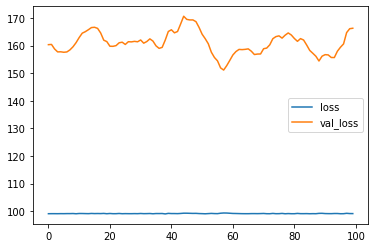

In [14]:
_ = plt.plot(history.history['loss'][-100:], label='loss')
_ = plt.plot(history.history['val_loss'][-100:], label='val_loss')
_ = plt.legend()
_ = plt.show()

There were 0 negative predictions
1-step MSE [Naive, nn model] = [178.40130492805756,99.10676855447633]
1-step R^2 [Naive, nn model] = [0.8725676047705556,0.9298994128519656]


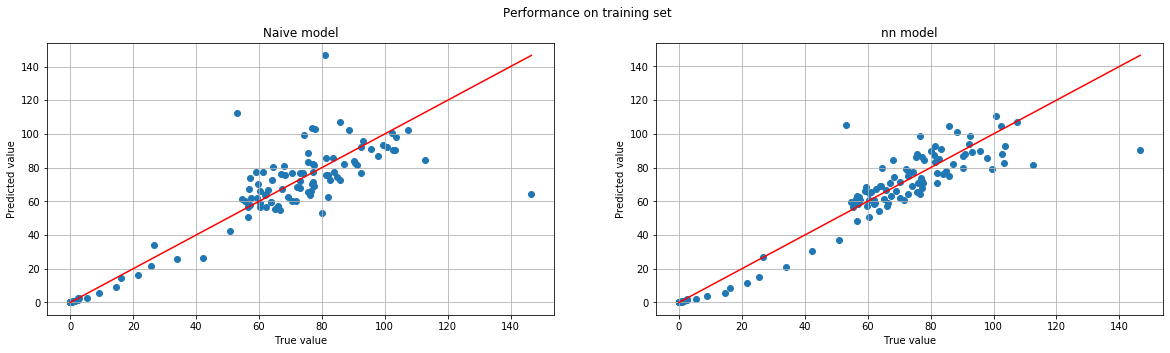

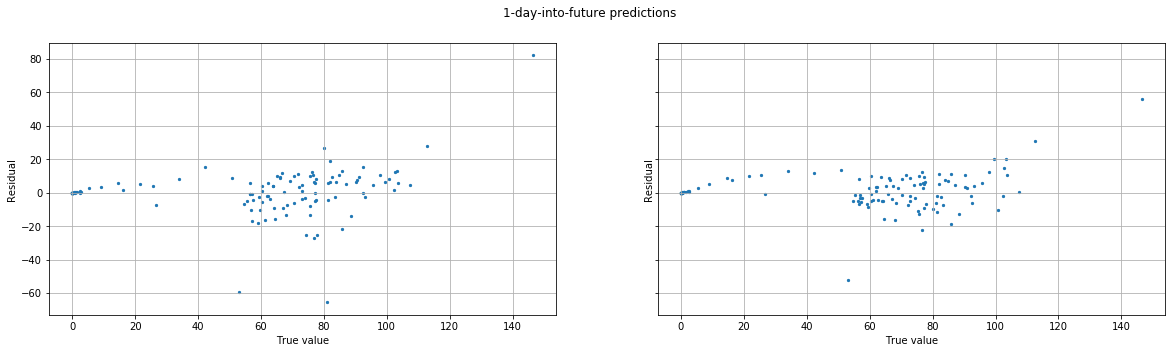

146.612 146.612 110.72986


In [15]:
y_true = y_nn_train_model.ravel()
y_predict = nn.predict(X_nn_train_model).ravel()
model_analysis(y_true, y_train_naive, y_predict, n_countries, title='nn model', suptitle='Performance on training set')
print(y_true.max(),y_train_naive.max(), y_predict.max())

There were 0 negative predictions
1-step MSE [Naive, nn model] = [170.80669257142873,166.29777468129095]
1-step R^2 [Naive, nn model] = [0.2994526992709322,0.5223302852514945]


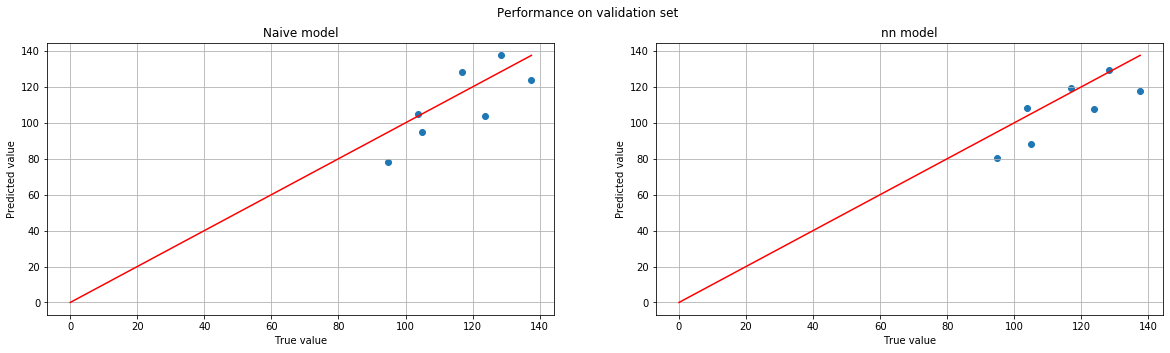

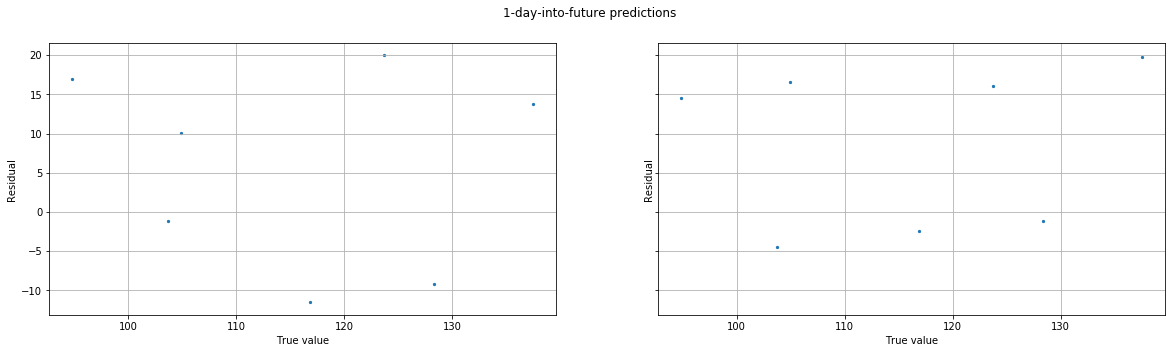

137.543 146.612 129.47035


In [16]:
y_true = y_nn_validate_model.ravel()
y_predict = nn.predict(X_nn_validate_model).ravel()
model_analysis(y_true, y_validate_naive, y_predict, n_countries, title='nn model', suptitle='Performance on validation set')
print(y_true.max(),y_train_naive.max(), y_predict.max())

# Unpruned

train
There were 0 negative predictions
1-step MSE [Naive, nn model] = [178.40130492805756,99.34188524751067]
1-step R^2 [Naive, nn model] = [0.8725676047705556,0.9294937982025111]

validate
There were 0 negative predictions
1-step MSE [Naive, nn model] = [170.80669257142873,159.82146675084758]
1-step R^2 [Naive, nn model] = [0.2994526992709322,0.5342048502113294]

# pruned

same validate, worse train





# frame size 28


# Convolutional neural network model


The convolution will be with respect to time, specifically the time steps within frames of time of predetermined length. This brings along with it a number of important details and challenges, such as ensuring the convolution is indeed in the right dimension and that time-ordering is being respected by the training and validation process. The manner in which this is handled also has to be compatible with the keras API. The preprocessing is the same as that for the neural network, only that this time the input is not flattened until after the convolutional layers. So, proceeding as before, I do some redundant calculations here for the sake of modularity:

In [17]:
X, y = create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames)

scaled_splits, scaling_arrays =  normalize_Xy(splits, feature_range=(0,1.0), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)
# if need to supply folds for sklearn CV regression functions.
(X_cnn_train, y_cnn_train, X_cnn_validate, y_cnn_validate, X_cnn_test, y_cnn_test) = splits
(train_indices, validate_indices, test_indices) = indices

X_cnn_train_model = np.concatenate(X_cnn_train.reshape(X_cnn_train.shape[0], X_cnn_train.shape[1], -1), axis=0)[:,:,np.newaxis]
X_cnn_validate_model = np.concatenate(X_cnn_validate.reshape(X_cnn_validate.shape[0], X_cnn_validate.shape[1], -1), axis=0)[:,:,np.newaxis]
X_cnn_test_model = np.concatenate(X_cnn_test.reshape(X_cnn_test.shape[0], X_cnn_test.shape[1], -1), axis=0)[:,:,np.newaxis]
y_cnn_train_model = y_cnn_train.ravel()
y_cnn_validate_model = y_cnn_validate.ravel()
y_cnn_test_model = y_cnn_test.ravel()

X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index].ravel()
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index].ravel()
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index].ravel()

Starting with frame ranging time_index values: 0 13
Ending with frame ranging time_index values: 146 159


The architecture of the CNN itself is two convolutional layers followed by two dense layers, ending with a ReLU activation layer. The parameters for the convolutional layers are the number of filters and the kernel size of the convolutions. The number of filters is much larger than the second because the desire is to pick up on many small patterns and then use them in combination to form larger ones. As far as I know this is the best way of doing so. There is no real argument for the convolutional kernel size other than they cannot be too large because the number of time steps are themselves small in number.

In [18]:
kernel0 = RandomNormal(seed=0)
kernel1 = RandomNormal(seed=1)
kernel2 = RandomNormal(seed=2)
kernel3 = RandomNormal(seed=3)

In [19]:
epochs = 1000
learning_rate = 0.001
kernel = 4
N = 8
FC = 8
batch_size = X_cnn_train.shape[0]

f1, f2 = 64, 4
k1, k2 = 4, 4

cnn = Sequential()


cnn.add(Conv1D(filters=int(f1), kernel_size=int(k1),
                 padding='valid',
                 input_shape=X_cnn_train.shape[2:],
               kernel_initializer=kernel0,
                )
         )

cnn.add(Conv1D(filters=int(f2), 
                 kernel_size=int(k2), 
                 padding='valid',
               kernel_initializer=kernel1,
                )
         )

cnn.add(Flatten())


cnn.add(Dense(cnn.output.shape[1],
              kernel_initializer=kernel2,
             )
       )


cnn.add(Dense(1, 
                activation='relu',
              kernel_initializer=kernel3,

                   ))
cnn.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py:61: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif not isinstance(value, collections.Sized):


Fit the model.

In [20]:
history = cnn.fit(X_cnn_train_model, y_cnn_train_model, epochs=epochs, validation_data=(X_cnn_validate_model, y_cnn_validate_model), 
          batch_size=batch_size, verbose=0)

Plot the training and validation loss curves to check for overfitting.

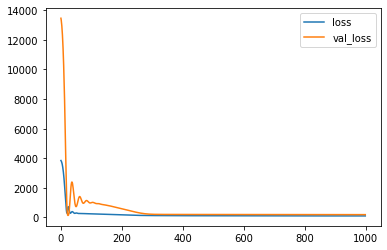

In [21]:
_ = plt.plot(history.history['loss'], label='loss')
_ = plt.plot(history.history['val_loss'], label='val_loss')
_ = plt.legend()
_ = plt.show()

Plot the results of predicting the training set.

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [178.40130492805756,96.73226745800719]
1-step R^2 [Naive, CNN model] = [0.8725676047705556,0.9307820967707766]


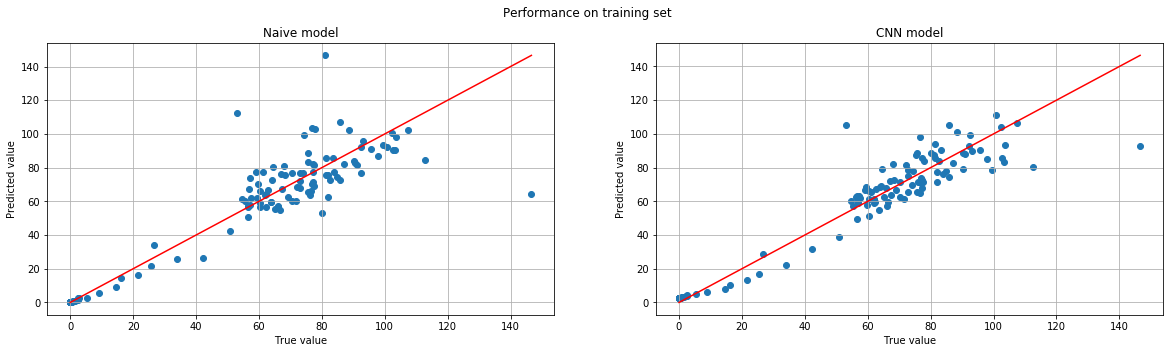

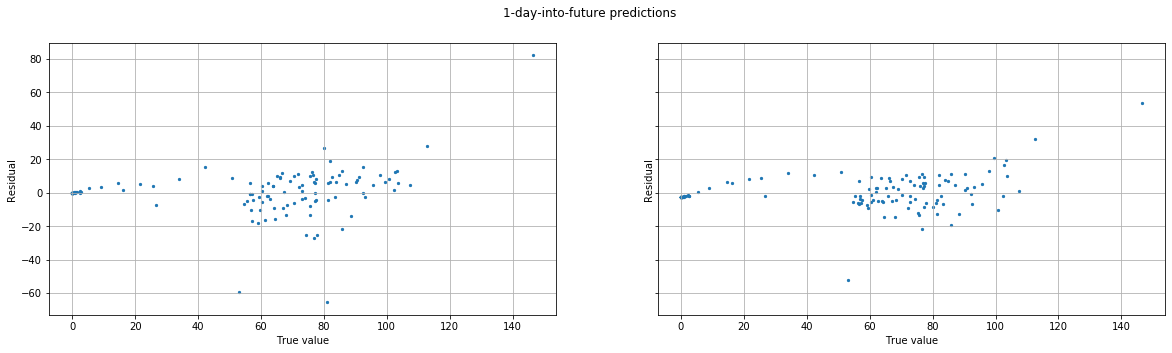

146.612 146.612 110.97189


In [22]:
y_true = y_cnn_train_model.ravel()
y_predict = cnn.predict(X_cnn_train_model).ravel()
model_analysis(y_true, y_train_naive, y_predict, n_countries, title='CNN model', suptitle='Performance on training set')
print(y_true.max(),y_train_naive.max(), y_predict.max())

Plot the results of predicting the validation set.

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [170.80669257142873,183.490868011023]
1-step R^2 [Naive, CNN model] = [0.2994526992709322,0.523319985285285]


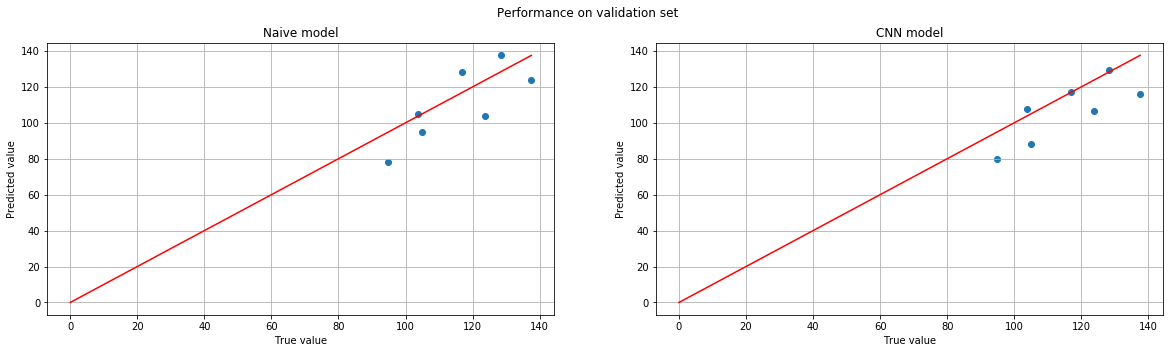

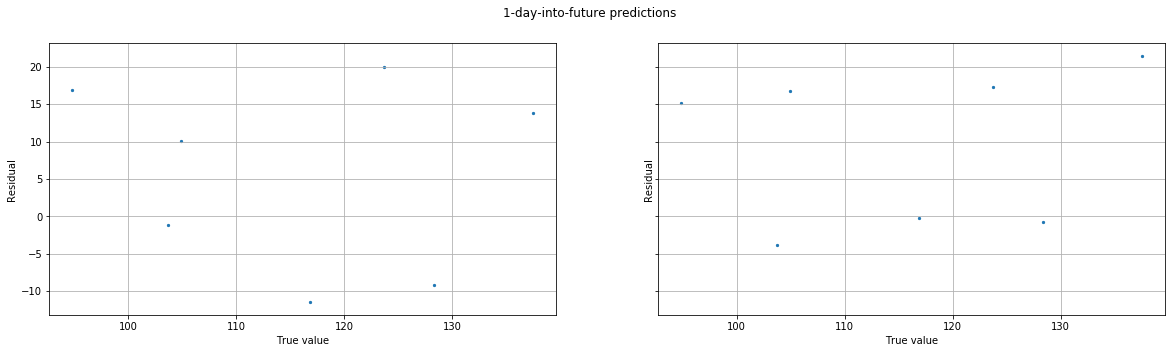

137.543 146.612 129.14519


In [23]:
y_true = y_cnn_validate_model.ravel()
y_predict = cnn.predict(X_cnn_validate_model).ravel()
model_analysis(y_true, y_validate_naive, y_predict, n_countries, title='CNN model', suptitle='Performance on validation set')
print(y_true.max(),y_train_naive.max(), y_predict.max())

A summary of the network for convenience.

In [24]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 11, 64)            320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 4)              1028      
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 2,437
Trainable params: 2,437
Non-trainable params: 0
_________________________________________________________________


# Regression

For different kinds of comparisons, I will use Ridge regression on two different datasets (technically two different subsets of the same dataset). The first model uses only the single feature used in the neural network modeling; for a "fair" comparison.

I do not use scaling because previous investigations not included here showed that scaling hurt the performance, using mean squared error as a metric. 

In [25]:
r_data = pd.read_csv('regression_data.csv', index_col=0)
r_data = r_data[r_data.location == 'United States']

In [26]:
# pandemic_start_date_median = r_data[r_data.days_since_first_case == 1].time_index.median()
# r_data[r_data.days_since_first_case==int(r_data.time_index.max()-pandemic_start_date_median)].location.nunique()
# new_dates = r_data[r_data.time_index>=60]
# dates_with_days_since_first_case_equals_zero = new_dates.groupby('location').days_since_first_case.min()
# countries_to_drop = dates_with_days_since_first_case[dates_with_days_since_first_case==0].index
# r_data = new_dates[~new_dates.location.isin(countries_to_drop)]

Again for the sake of modularity, perform some redundant calculations.

In [27]:
# modeling_features = ['new_cases_per_million', 'stringency_index', 'log_new_cases_per_million']
# model_r_data = r_data.copy().loc[:, modeling_features]

In [28]:
new_cases_index = column_search(model_r_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
n_countries = r_data.location.nunique()
target_r_data = r_data.new_cases_per_million
time_index = r_data.time_index

frame_size = 28
start_date = frame_size + r_data.time_index.min()

n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1

NameError: name 'model_r_data' is not defined

In [ ]:
r_model_data = r_data.new_cases_per_million.to_frame().copy(); new_cases_index=0
new_cases_index = column_search(r_model_data,'new_cases_per_million',threshold='match', return_style='iloc')[0]
n_countries = r_data.location.nunique()
target_data = r_data.new_cases_per_million
time_index = r_data.time_index.astype(int)
frame_size = 14
start_date = frame_size + time_index.min()
n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1
train_or_test = 'train'

X, y = create_Xy(r_model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames,model_type='ridge')
(train_indices, validate_indices, test_indices) = indices
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)

y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index]
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index]
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index]

flat_splits = flatten_Xy_splits(splits)
(X_regression_train, y_regression_train, X_regression_validate,
 y_regression_validate, X_regression_test, y_regression_test) = flat_splits

I want to use a different metric other than explained variance as a metric; the easiest way of doing so is to use RidgeCV and pass it a scoring function. I also provide the indices of the training and testing folds; of which there is only one, so that the data used to train this model and the neural networks are the same. The cross validation ranges over some alpha values (regularization constant).

In [ ]:
X_regression = np.concatenate((X_regression_train, X_regression_validate),axis=0)
y_regression = np.concatenate((y_regression_train, y_regression_validate),axis=0)

scorer = make_scorer(mean_squared_error, greater_is_better=False)
ridge = RidgeCV(scoring=scorer, cv=[[train_indices, validate_indices]]) 
_ = ridge.fit(X_regression, y_regression)

The predictions of the training set.

In [ ]:
y_predict_train = ridge.predict(X_regression_train).ravel()

model_analysis( y_regression[train_indices].ravel(), y_train_naive, y_predict_train, 
               n_countries, title='Ridge regression model', suptitle='Performance on training set')

The predictions of the validation set.

In [ ]:
y_predict_validate = ridge.predict(X_regression_validate).ravel()
model_analysis( y_regression_validate.ravel(), y_validate_naive, y_predict_validate, n_countries,title='Ridge regression model', suptitle='Performance on validation set')

# Regression with all features

This second regression model contains most of the time-dependent features as well as their corresponding rolling features (rolling averages and standard deviations).

This is partly a sneak peak into the notebook on regression, ```COVID19_regression.ipynb``` and partly a demonstration of evidence that supports the claim that regression performs much better with more feature information, in terms of the prediction on the validation set, but actually performs much worse on the testing set. The next few cells are basically the same as above, so they 

In [ ]:
# r_data = r_data.drop(columns=column_search(r_data,'flag'))
# r_data = r_data.drop(columns=column_search(r_data,'test'))
# r_data = r_data.drop(columns=column_search(r_data,'deaths'))
# r_data = r_data.drop(columns=column_search(r_data,'recovered'))
# r_data = r_data.drop(columns=column_search(r_data,'14'))
# r_data = r_data.drop(columns=column_search(r_data,'region'))
# r_data = r_data.drop(columns=column_search(r_data,'continent'))
# r_data = r_data.drop(columns=column_search(r_data,'location_flag'))
# r_data = r_data.drop(columns=column_search(r_data,'missing'))
# r_data = r_data.drop(columns=column_search(r_data,'log'))
# r_data = r_data.drop(columns=column_search(r_data,'std'))
# r_data = r_data.drop(columns=r_data.iloc[:,7:44].columns)

In [ ]:
r_model_data = r_data.iloc[:,2:].copy()
new_cases_index = column_search(r_model_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
n_countries = r_data.location.nunique()
target_data = r_data.new_cases_per_million
time_index = r_data.time_index.astype(int)
frame_size = 14
start_date = frame_size
n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1
train_or_test = 'train'

X, y = create_Xy(r_model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames,model_type='ridge')
(train_indices, validate_indices, test_indices) = indices

(X_train, y_train, X_validate,
 y_validate, X_test, y_test) = splits

n_features = X.shape[-1]
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index]
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index]
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index]

Before we proceed, let's check that the data is organized as we expect, as this time around we are using more than a single feature.

In [ ]:
new_cases_indices = np.ravel_multi_index([list(range(frame_size)),[new_cases_index]],(frame_size, n_features))
new_cases_indices

In [ ]:
flat_splits = flatten_Xy_splits(splits)
(X_regression_train, y_regression_train, X_regression_validate,
 y_regression_validate, X_regression_test, y_regression_test) = flat_splits

In [ ]:
# The first frame should have time values from 0 to 27.
r_model_data.new_cases_per_million.iloc[:frame_size].values-X_regression_train[0, new_cases_indices]

In [ ]:
# The last row or last frame, should have values from time_index.max()-1-n_test_frames-n_validation_frames-frame_size to time_index.max()-1-n_test_frames-n_validation_frames
(r_model_data.new_cases_per_million.iloc[-frame_size-n_test_frames-n_validation_frames-1:-n_test_frames-n_validation_frames-1].values
 -X_regression_train[-1, new_cases_indices])

Now that the data is at least ordered how I expect, proceed with the modelling.

In [ ]:
X_regression = np.concatenate((X_regression_train, X_regression_validate),axis=0)
y_regression = np.concatenate((y_regression_train, y_regression_validate),axis=0)

scorer = make_scorer(mean_squared_error, greater_is_better=False)
ridge_all_features = RidgeCV(scoring=scorer, cv=[[train_indices, validate_indices]]) 
_ = ridge_all_features.fit(X_regression, y_regression)

As previously seen, predict on the training and validation data.

In [ ]:
y_predict_train = ridge_all_features.predict(X_regression_train).ravel()
model_analysis(y_regression_train, y_train_naive, y_predict_train, n_countries, title='Ridge', suptitle='Scaled predictor training set performance')

In [ ]:
y_predict_validate = ridge_all_features.predict(X_regression_validate).ravel()
model_analysis(y_regression_validate, y_validate_naive, y_predict_validate, n_countries, title='Ridge', suptitle='Scaled predictor validation set performance')

# Final predictions for comparison

As a final measure of the potency of each prototype model, perform predictions on the test data. Because these models are only using a single countries data, I do not view this as snooping the holdout set.

In [ ]:
y_naive = y_test_naive
y_true = y_test
y_predict_r = ridge_all_features.predict(X_regression_test)
y_predict_c = cnn.predict(X_cnn_test_model)
y_predict_n = nn.predict(X_nn_test_model)

While the ridge regression trained on all of the feature data performs very well on the training and validation sets, it does not perform well on the testing set. Presumably this is because I did not retrain the data on the combination of training and validation; i.e. it is using a model which is only trained up to a week into the past. I find this sufficient for these prototype models, however.

In [ ]:
s = 200
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5),sharey=True)

ymax = np.max([y_true.max(), y_predict.max()])
ax1.plot([0, ymax], [0, ymax],color='r')
ax1.scatter(y_true, y_predict_r, s=s)
ax2.plot([0, ymax], [0, ymax],color='r')
ax2.scatter(y_true, y_predict_c, s=s)
ax3.plot([0, ymax], [0, ymax],color='r')
ax3.scatter(y_true, y_predict_n, s=s)

ax1.set_xlabel('True value')
ax1.set_ylabel('Predicted value')
ax1.set_title('Ridge residual '+str(y_predict_r.ravel()[0]-y_true.ravel()[0]))

ax2.set_xlabel('True value')
ax2.set_ylabel('Predicted value')
ax2.set_title('CNN residual '+str(y_predict_c.ravel()[0]-y_true.ravel()[0]))

ax3.set_xlabel('True value')
ax3.set_ylabel('Predicted value')
ax3.set_title('NN residual '+str(y_predict_n.ravel()[0]-y_true.ravel()[0]))

ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
plt.suptitle('Model comparison on hold-out set')
plt.show()

# Appendix

Some comments on the relation between X slicing and the original data: 

    X[-1, :, -1, 2] = model_data.time_index.max() - n_days_into_future 
    X[-t, :, -1, 2] = (model_data.time_index.max() - n_days_into_future + 1) - t

Because ```n_days_into_future == 1``` throughout this notebook, the most recent date in the last frame of X is data.time_index.max()-1.
The maximum time_index of the data in y is data.time_index().max(). Therefore, to convert, we have
    
    X[-1,:,-1,:] = y[-2, :]
    
or, more generally, 

    X[-t,:,-1,:] = y[-(n+t), :]
    
This shows that the staggering has been done correctly. That is, each entry along the first axis of X predicts.
Need to make sure that the naive predictions are being chosen correctly. To do so, just look at the instance
where n_frames_validation == 1 and n_frames_test == 1 (to make slicing easier) for n_days_into_future == 7.

Therefore, when n_validation_frames > 1, the breakdown of the data is as follows:

    Naive predictions = X[validation_indices, :, -1, 2]
    CNN predictions = model.predict(X[validation_indices, :, :, :])
    True future values = y[validation_indices, :]
    
Where validation indices is assumed to be a correctly formatted array of indices. 
